In [1]:
#= 
first section (first 337 lines) has all the functions (external to Luna) and variables/parameters used
second section is where the 1st is propagated
third section is where the 2nd and 3rd section can be run for one or various: pressures/energies based on second index of array (input pulse duration to stg3)
the following sections produces various graphs based on the stage3 arrays run

The first stage (stg1) fiber to broaden bandwidth then compress 160 fs pulse to ~21 fs with a series of optical components including chirp mirrors
The second stage (stg2) fiber broadens bandwidth even more then compresses the pulse further down to ~5 to 11fs (based on array index a, i.e. gas2[a]) with different but similar series of optical components including chirp mirrors and wedges
Lastly, the third stage (stg3) is the soliton stage which is where the UV RWD emission is generated via adjusting the pressure of neon and the input energy of the pulse (to limit ionization), based on array i.e. gas3[a,i] where a is the pulse chosen in the second fiber and i corresponds to column index; compressor_stg3 is indexed in a similar manner 
=#

In [2]:
#= Array simulation:
  Check stage 1 parameters are correct:
        gas1 = :Kr		#gas in the fiber, Kr is krypton 
        energy1 = 340e-6	#pulse energy in Joules
        pressure1 = 2.7		#gas pressure in bar
  Set stage 2 parameters by using a preset listed - only need to set a=1,2,3,4 corresponding the the index in block where stg2 function is ran
        gas2= Array([     :Ne,  :Ar,   :Ar,    :Ar])
        energy2= Array([500e-6, 250e-6, 200e-6, 180e-6]) #corresponds to 5.29, 7.37, 9.21, 10.74fs output after compression of 2nd stage fiber, a indexes this array in the below functions
        pressure2= Array([5.5,   0.7,    0.5,    0.4])
  Set stage 3 as a 2D array; a indexes the row (corresponds to varying pulse durations), i indexes the coloumn (13 total)
        for loops are used to iterate through multiple input pulse durations and pressure/energy/gas combinations
=#

In [3]:
using Luna  #declare package to use propagation functions, need to add to Julia REPL before first use, see GitHub for documentation
import PyPlot as plt #for some plotting
using Plots #for some other plotting
gr() #backend for Plots

##global variables:
    #parameters of input pulse using the Pharos laser
    λ0 = 1030e-9	    #central wavelength in meters
    τfwhm_initial= 165e-15	#pulse duration in seconds
    #parameters of the first fiber
    a1 = 268e-6		#core radius in meters
    flength1 = 1.0 	#fiber length in meters
    gas1 = :Kr		#gas in the fiber, Kr is krypton 
    energy1 = 350e-6	#pulse energy in Joules
    pressure1 = 2.7		#gas pressure in bar
    #parameters of the second fiber
    a2 = 268e-6		#core radius in meters
    flength2 = 1.8 	#fiber length in meters
    gas2= Array([     :Ne,  :Ar,   :Ar,    :Ar]) #next 3 arrays are indexed via variable a
    energy2= Array([500e-6, 250e-6, 200e-6, 180e-6]) #corresponds to 5.29, 7.37, 9.21, 10.74fs output after compression of 2nd stage fiber, a indexes this array in the below functions
    pressure2= Array([5.5,   0.7,    0.5,    0.4])
    #parameters of the third fiber
    a3 = 100e-6		#core radius in meters
    flength3 = 1	#fiber length in meters
                        #a=1, 5.29fs                                                                                a=2 7.37fs                                                                                            a=3 9.21fs                                                                                  a=4 10.74
    gas3= Array([       :He   :He    :He     :Ne    :Ne    :Ne   :Ne    :Ne   :Ne    :Ar  :Ar    :Ar   :Ar  ;    :He   :He    :He      :Ne    :Ne     :Ne    :Ne    :Ne     :Ne    :Ar    :Ar      :Ar   :Ar   ;   :He    :He    :He    :Ne      :Ne     :Ne    :Ne    :Ne       :Ne    :Ar  :Ar   :Ar     :Ar  ; :He     :He    :He     :Ne    :Ne    :Ne     :Ne    :Ne   :Ne    :Ar  :Ar    :Ar     :Ar  ]) #arrays: row=a, column= i or j; row is determined by pulse duration
    energy3= Array([   230e-6 210e-6 160e-6 145e-6 135e-6 110e-6 85e-6  75e-6 65e-6 40e-6 25e-6  20e-6 20e-6; 250e-6  220e-6  190e-6  180e-6  155e-6  120e-6 100e-6  95e-6  80e-6  50e-6  40e-6  30e-6   25e-6  ;  225e-6  225e-6 200e-6  175e-6  155e-6  150e-6 100e-6  100e-6  90e-6  60e-6  50e-6 40e-6 35e-6 ; 260e-6 230e-6 210e-6  190e-6  165e-6 140e-6 110e-6 105e-6 90e-6  60e-6 50e-6   40e-6 35e-6]) #corresponds to UV tuning chart based on the state of stg2 pulse duration
    pressure3= Array([   2.0   2.5    3.0     1.5    2.0    2.5   3.0   3.5    4.0   0.5   0.6   0.7    0.8  ;   2.0     2.5    3.0     1.5      2.0     2.5   3.0      3.5    4.0    0.5    0.6      0.7     0.8 ; 2.0   2.5     3.0     1.5     2.0   2.5       3.0      3.5    4.0    0.5   0.6    0.7    0.8;   2.0    2.5    3.0     1.5    2.0    2.5    3.0    3.5    4.0    0.5    0.6      0.7     0.8])
    #for stg1, stg2, stg3 functions to make arrays which are mutuable in and out of functions
    compressor_stg1 =  Array{Any}(undef,1) #only using the first index but need array since mutuable in/out of functions
    compressor_stg2 =  Array{Any}(undef,6) #one index for each tested output pulse duration
    compressor_stg3 =  Array{Any}(undef,5,100) #arbituary chosen size; first index corresponds to stg2[a] for LunaPulse, second is the properties incoming to 3rd stage
    #plotting/grid parameters
    FTL=false #turns off the transformed limited case
    modes= 4 		 #total number of modes
    trange1 = 1e-12 	    #time grid size in seconds
    λrange1=(700e-9, 1200e-9) #grid wavelength range in meters for plots for graphs
    λlims_stg1 = (700e-9, 1200e-9) #grid wavelength range in meters for fibers for propagation
    trange2 = 500e-15  	    #time grid size in seconds 
    λrange2=(700e-9, 1200e-9) #grid wavelength range in meters for graphs
    λlims_stg2 = (200e-9, 3e-6) #grid wavelength range in meters for fibers for propagation
    trange3 = 300e-15	    #time grid size in seconds
    λrange3= (100e-9, 1400e-9) #grid wavelength range in meters for graphs
    λlims_stg3 = (100e-9, 1400e-9) #grid wavelength range in meters for fibers for propagation
    pt2=plot()#variable to store graph in until ready to display



##functions:

#:::'##::::'######::'########:::::'######::'########::::'###:::::'######:::'########:
#:'####:::'##... ##:... ##..:::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#:.. ##::: ##:::..::::: ##::::::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#::: ##:::. ######::::: ##:::::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#::: ##::::..... ##:::: ##::::::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
#::: ##:::'##::: ##:::: ##:::::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
#:'######:. ######::::: ##:::::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#:......:::......::::::..:::::::::......::::::..:::::..:::::..:::......::::........::

#simulates the pulse down the first fiber
function stg1(gas, energy, pressure)
    #propagate through the first stage fiber to broaden bandwidth with the parameters listed above
    compressor_stg1[1]= prop_capillary(a1, flength1, gas, pressure; λ0=λ0, τfwhm=τfwhm_initial, energy, λlims=λlims_stg1, trange=trange1, modes) 
end
        
#compress in time the first stage with chirp mirrors
#physical order in lab: 1m of fiber>window>lens>2m of air>chirp mirrors>2m of air>lens>window>next fiber
# this mutates its input as required for the LunaPulse
function prop1!(Eω, grid)
    Fields.prop_material!(Eω, grid, :SiO2, 1e-3, λ0) # 1 1-mm window
    Fields.prop_material!(Eω, grid, :BK7, 2.1e-3, λ0) # 1 bk7 lens LA1254-Bc thorlabs
    Fields.prop_material!(Eω, grid, :Air, 2, λ0) # 2m of air
    Fields.prop_mirror!(Eω, grid, :HD120, 4) #4 chirp mirror bounces
    Fields.prop_material!(Eω, grid, :Air, 2, λ0) # 2m of air path total
    Fields.prop_material!(Eω, grid, :BK7, 2.1e-3, λ0) # 1 bk7 lenses LA1254-Bc thorlabs
    Fields.prop_material!(Eω, grid, :SiO2, 1e-3, λ0) # 1 1-mm window

end
    
# non-mutating version of prop! as required for plotting
function prop1(grid, Eω)
    Eωout = copy(Eω)
    prop1!(Eωout, grid)
    Eωout
end


#:'#######::'##::: ##:'########::::::'######::'########::::'###:::::'######:::'########:
#'##.... ##: ###:: ##: ##.... ##::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#..::::: ##: ####: ##: ##:::: ##:::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#:'#######:: ## ## ##: ##:::: ##::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#'##:::::::: ##. ####: ##:::: ##:::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
# ##:::::::: ##:. ###: ##:::: ##::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
# #########: ##::. ##: ########:::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#.........::..::::..::........:::::::......::::::..:::::..:::::..:::......::::........::

#simulates the pulse down the second fiber
function stg2(a, gas, energy, pressure) 
    #obtain pulse from the first fiber end via LunaPulse
     pulse_in_stg2 = Pulses.LunaPulse(compressor_stg1[1]; energy, propagator=prop1!) #input pulse from the 1st stage
    #propagate through the second stage fiber to broaden bandwidth even more, with parameters listed above
    compressor_stg2[a]= prop_capillary(a2, flength2, gas, pressure; pulses=[pulse_in_stg2], λ0=λ0, trange=trange2, λlims=λlims_stg2, modes=modes)
end

#compress in time the second stage with chirp mirrors and other optical components
#=physical order in lab: First fiber>optical components>second fiber> 1mm fused silica window >4-5 m of air path length >1mm MgF2 window> 4 (2 pairs) of PC147 chirped mirrors from ultrafast innovations 6 (3 pairs) of PC147 chirped mirrors from ultrafast innovations  > 3.5mm fused silica polarizer > wedges >third fiber     =#
#this mutates its input as required for the LunaPulse
function prop2!(Eω, grid)
    Fields.prop_material!(Eω, grid, :SiO2, 1e-3, λ0) # 1 1-mm fused silica window 
    Fields.prop_material!(Eω, grid, :Air, 3.9, λ0) # 4m of air total
    Fields.prop_material!(Eω, grid, :MgF2, 1e-3, λ0) #1mm Magnesium Fluoride window
    Fields.prop_mirror!(Eω, grid, :PC147, 4) #4 chirped mirror bounces (not pairs but need to be in multiples of 2 due to the material induced out of phase oscillations of GDD)
    Fields.prop_material!(Eω, grid, :SiO2, 3.5e-3, λ0) # 1 3.5 mm fused silica polarizer
  _, Eωopt = Fields.optcomp_material(Eω, grid, :MgF2, λ0, -1e-2, 1e-2) #wedges for optimizing compression, last numbers are  min_thickness then max_thickness
  Eω .= Eωopt
end

# non-mutating version of prop! as required for plotting
function prop2(grid, Eω)
    Eωout = copy(Eω)
    prop2!(Eωout, grid)
    Eωout
end

#:'#######::'########::'########::::::'######::'########::::'###:::::'######:::'########:
#'##.... ##: ##.... ##: ##.... ##::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#..::::: ##: ##:::: ##: ##:::: ##:::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#:'#######:: ########:: ##:::: ##::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#:...... ##: ##.. ##::: ##:::: ##:::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
#'##:::: ##: ##::. ##:: ##:::: ##::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
#. #######:: ##:::. ##: ########:::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#:.......:::..:::::..::........:::::::......::::::..:::::..:::::..:::......::::........::

#simulates the pulse down the third fiber
function stg3(a, i, gas3, energy3, pressure3, infunc) 
    #obtain pulse from the first fiber end via LunaPulse
    pulse_in_stg3 = Pulses.LunaPulse(infunc; energy=energy3, propagator=prop2!) #input pulse from the 2nd stage
    #propagate through the second stage fiber to broaden bandwidth even more, with parameters listed above
    compressor_stg3[a,i]= prop_capillary(a3, flength3, gas3, pressure3; pulses=[pulse_in_stg3], λ0=λ0, trange=trange3, λlims=λlims_stg3, modes=modes)
end

#:'######:::'########:::::'###::::'########::'##::::'##::'######::
#'##... ##:: ##.... ##:::'## ##::: ##.... ##: ##:::: ##:'##... ##:
# ##:::..::: ##:::: ##::'##:. ##:: ##:::: ##: ##:::: ##: ##:::..::
# ##::'####: ########::'##:::. ##: ########:: #########:. ######::
# ##::: ##:: ##.. ##::: #########: ##.....::: ##.... ##::..... ##:
# ##::: ##:: ##::. ##:: ##.... ##: ##:::::::: ##:::: ##:'##::: ##:
#. ######::: ##:::. ##: ##:::: ##: ##:::::::: ##:::: ##:. ######::
#:......::::..:::::..::..:::::..::..:::::::::..:::::..:::......::

#graphs before compression 
function graphs_b4(func, range, bandpasss) 
    Plotting.time_1D(func; modes=1,  FTL=FTL, trange=(-300e-15, 300e-15), bandpass=bandpasss) 		
        #^^plot of power as function of time for the mode specified 
         #can add bandpass= to look at pulse duration for certain wavelegnths
    Plotting.spec_1D(func; log10=false, modes=1,  λrange=range)
        #^^ plots SED as function of wavelength for each mode
    Plotting.stats(func)
        #^^ plots lots of info about each mode
    Plotting.energy(func; modes=1, bandpass=bandpasss)
        #^^ graphs the energy as a function of distance for given wavelength range
end

#graphs after compression 
function graphs_after(func, propp, range, bandpasss) #where propp corresponds to prop1, or prop2 for compression
    Plotting.time_1D(func; modes=1, trange=(-300e-15, 300e-15), FTL=FTL, propagate=propp, bandpass=bandpasss) 		
        #^^plot of power as function of time for the mode specified 
        #can add bandpass= to look at pulse duration for certain wavelegnths
    Plotting.spec_1D(func; log10=false, modes=1, λrange=range)
        #^^ plots SED as function of wavelength for each mode
    Plotting.stats(func)
        #^^ plots lots of info about each mode
    Plotting.energy(func; modes=1, bandpass=bandpasss)
    #^^ graphs the energy as a function of distance for given wavelength range
end

#graphs the normalized SED vs wavelength, based on for loop from stg3
#some arrays may need the wavelegnth to be cut off later/sooner than the 1300
function graphs2_normSED_λ(func, j, a, pt1)
    #general plotting parameters
    plt.xlim(140, 550)
    plt.xlabel("Wavelength (nm)")
    plt.ylim(0,1)
    plt.ylabel("Normalized Spectral energy density")
    plt.title("Tuning RDW Emission with Gas Species and Pressure")
   # y=0 #fills under the curve in solid color
    #plotting arrays/variables
    λ= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

if j==1
        #gets SED and λ then normalizes SED to graph with legend 
    λ[j], Iλ[j]=Processing.getIω(compressor_stg3[a, j], :λ,1) #get values of from the compressor function
    λ[j]=first(λ[j],800) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 800) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot( λ[j]*1e9, Iλ_norm[j],  label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
elseif j==4
                    #gets SED and λ then normalizes SED to graph with legend 
    λ[j], Iλ[j]=Processing.getIω(compressor_stg3[a, j], :λ,1) #get values of from the compressor function
    λ[j]=first(λ[j],900) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 900) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot( λ[j]*1e9, Iλ_norm[j],  label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
            
else      
    #gets SED and λ then normalizes SED to graph with legend 
    λ[j], Iλ[j]=Processing.getIω(compressor_stg3[a, j], :λ,1) #get values of from the compressor function
    λ[j]=first(λ[j],1300) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 1300) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot( λ[j]*1e9, Iλ_norm[j],  label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
end
end


#graphs the normalized SED vs angular frequnecy, based on for loop from stg3
function graphs2_normSED_ω(func, j)
    
    #general plotting parameters
    plt.xlim(10e14, 30e14)
    plt.xlabel("Angular Frequency (rad/s)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Angular Frequency with varying gas and pressure")

    #plotting arrays/variables
    w= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    w[j], Iλ[j]=Processing.getIω(compressor_stg3[a, j], :ω,1) #get values of from the compressor function
    w[j]=first(w[j],1300) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 1300) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(w[j], Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
end

#graphs the normalized SED vs frequnecy, based on for loop from stg3
function graphs2_normSED_f(func, j)
    #general plotting parameters
    plt.xlim(100, 500)
    plt.xlabel("Frequency (THz)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Frequency with varying gas and pressure")

    #plotting arrays/variables
    f= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    f[j], Iλ[j]=Processing.getIω(func, :f,1) #get values of from the compressor function
    f[j]=first(f[j],1300) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 1300) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(f[j]*1e-12, Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
end

#graphs the normalized SED vs frequnecy, based on for loop from stg3
function graphs2_normSED_e(func,a, j)
        #general plotting parameters
    plt.xlim(0, 9)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Energy with varying gas and pressure")

    #plotting arrays/variables
    f= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    f[j], Iλ[j]=Processing.getIω(func, :f,1) #get values of from the compressor function
    print(size(f[j]))
    f[j]=first(f[j],1300) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 1300) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(f[j]*4.14e-15, Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
    print(size(f[j]))

end

#graphs the normalized SED vs frequnecy, based on for loop from stg3
function graphs2_normSED_ezoom(func,a, j)
        #general plotting parameters
    plt.xlim(6, 9)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Energy with varying gas and pressure")

    #plotting arrays/variables
    f= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    f[j], Iλ[j]=Processing.getIω(func, :f,1) #get values of from the compressor function
   # print(size(f[j]))
    f[j]=last(f[j],1000) #filter out data points greater than window to normalize properly
    Iλ[j]=last(Iλ[j], 1000) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(f[j]*4.14e-15, Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")

end

graphs2_normSED_ezoom (generic function with 1 method)

[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.25 - 0.43 PHz
[ Info: Samples needed: 2569.65, samples: 4096, δt = 389.16 as
[ Info: Requested time window: 1000.0 fs, actual time window: 1594.0 fs
[ Info: Grid: samples 2048 / 4096, ωmax 4.04e+15 / 8.07e+15
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 13.992094691484 eV, 1030.0 nm
[ Info: Using radial modal integral.
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Starting propagation
[ Info: Progress: 6.08 %, ETA: 00:01:17, stepsize 7.20e-03, err 0.37, repeated 0
[ Info: Progress: 50.71 %, ETA: 00:00:10, stepsize 4.65e-03, err 0.15, repeated 0
[ Info: Propagation finished in 14.603 seconds, 190 steps
sys:1: UserWarning: The figure layout has changed to tight


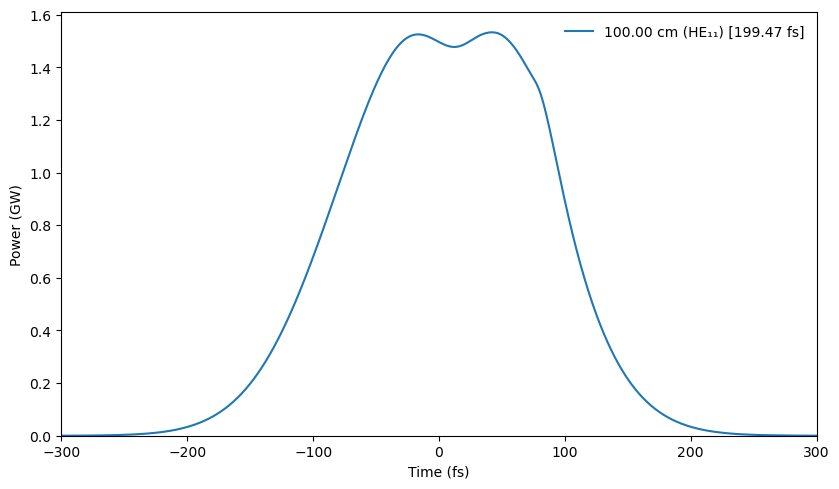

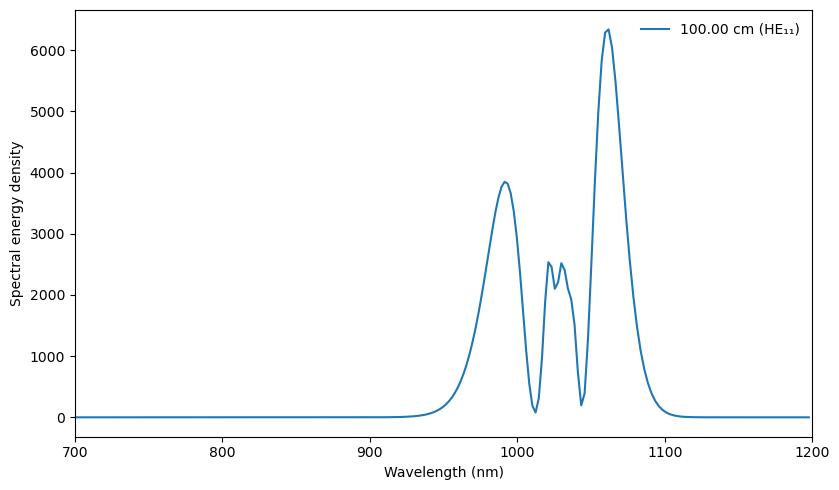

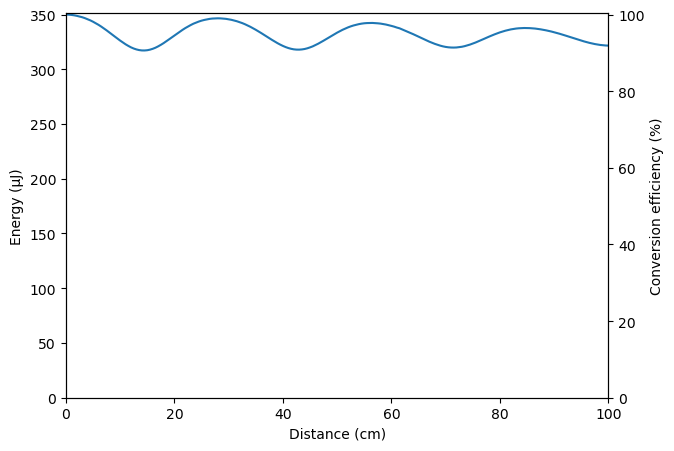

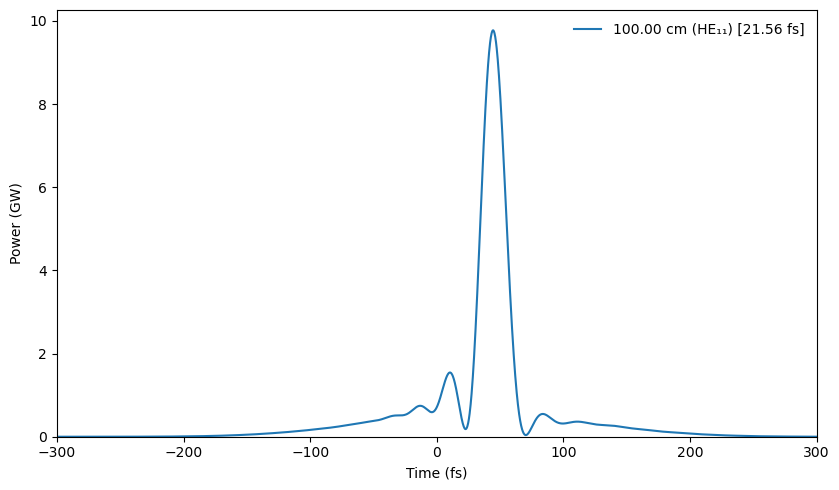

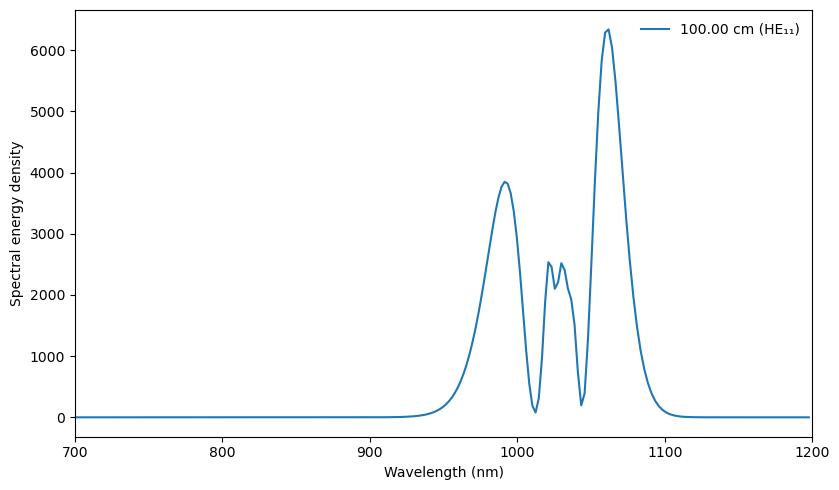

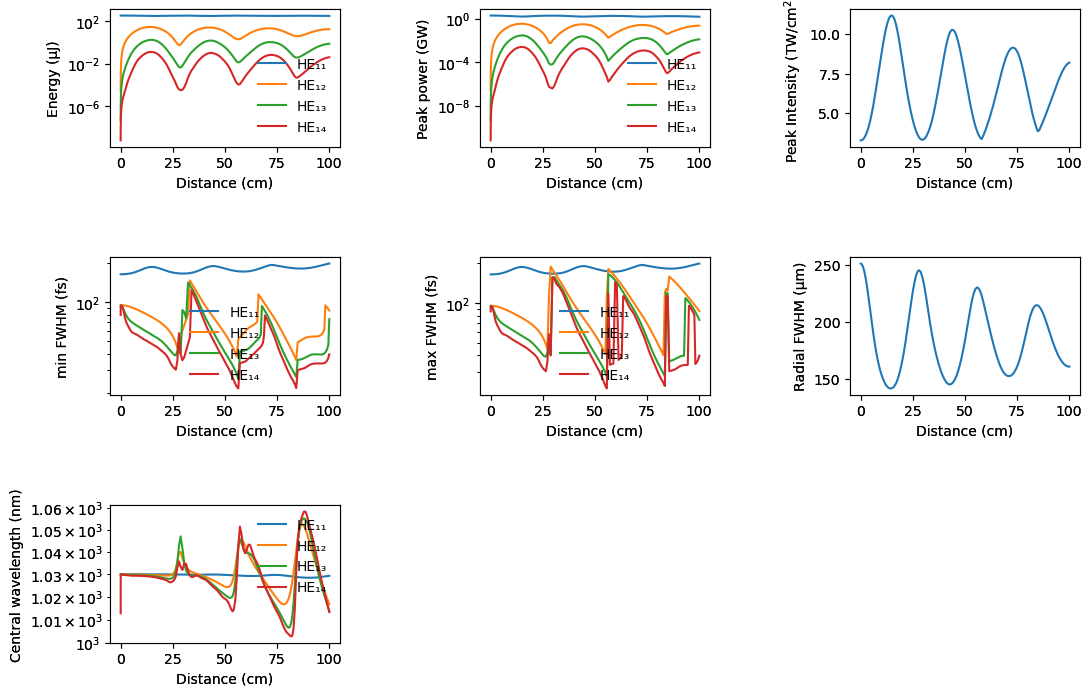

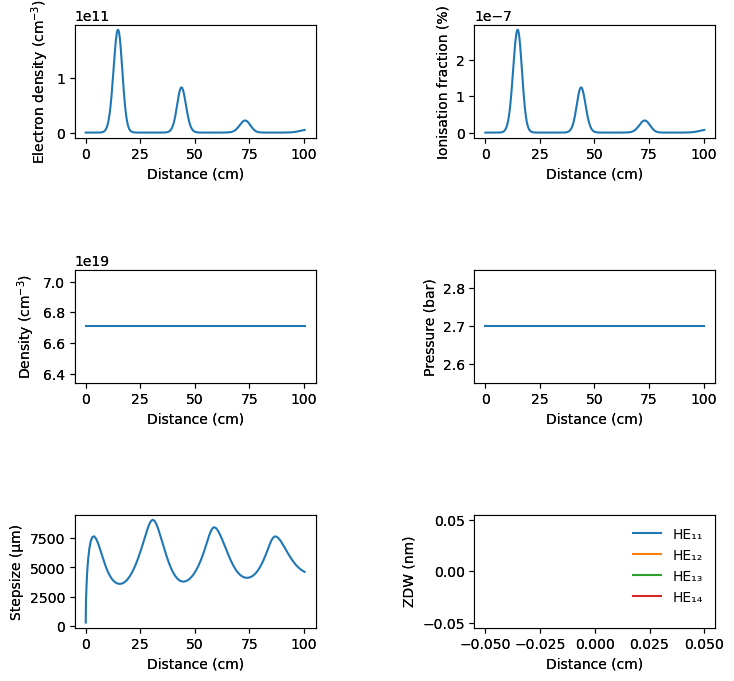

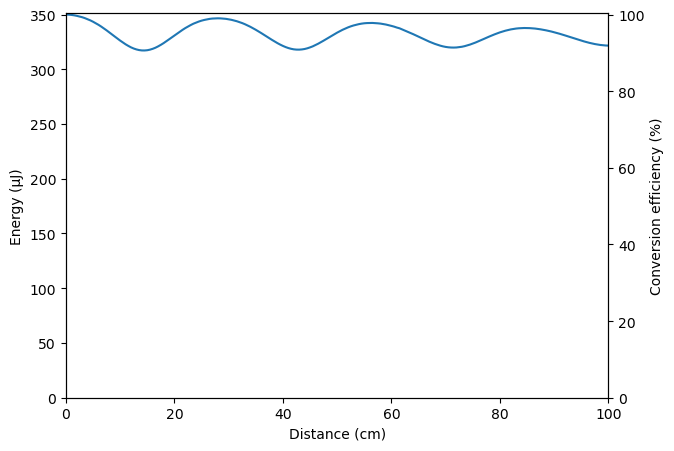

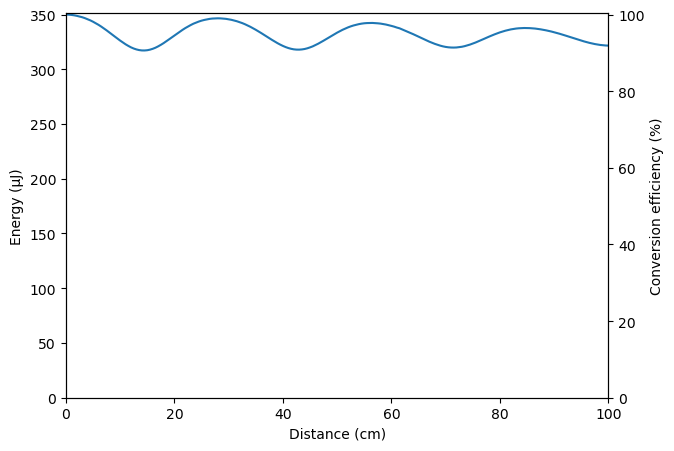

In [5]:
#:::'##::::'######::'########:::::'######::'########::::'###:::::'######:::'########:
#:'####:::'##... ##:... ##..:::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#:.. ##::: ##:::..::::: ##::::::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#::: ##:::. ######::::: ##:::::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#::: ##::::..... ##:::: ##::::::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
#::: ##:::'##::: ##:::: ##:::::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
#:'######:. ######::::: ##:::::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#:......:::......::::::..:::::::::......::::::..:::::..:::::..:::......::::........::
bandpass=λrange1 #bandwidth range for time domain graphs
stg1(gas1, energy1, pressure1) #use predefined function to simulate pulse down first fiber
graphs_b4(compressor_stg1[1], λrange1, bandpass) #plot pulse after first fiber before compression- function, predefined λrange in global variables  
graphs_after(compressor_stg1[1], prop1, λrange1, bandpass) #plot pulse after compression - prop1 for first fiber, predefined λrange in global variables 

[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.10 - 1.50 PHz
[ Info: Samples needed: 4496.89, samples: 8192, δt = 111.19 as
[ Info: Requested time window: 500.0 fs, actual time window: 910.9 fs
[ Info: Grid: samples 4096 / 8192, ωmax 1.41e+16 / 2.83e+16
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 15.760834782784002 eV, 1030.0 nm
[ Info: Using radial modal integral.
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Starting propagation
[ Info: Progress: 6.38 %, ETA: 00:01:14, stepsize 5.31e-03, err 0.28, repeated 0
[ Info: Progress: 15.00 %, ETA: 00:00:57, stepsize 3.71e-03, err 0.17, repeated 0
[ Info: Progress: 23.06 %, ETA: 00:00:50, stepsize 4.27e-03, err 0.29, repeated 0
[ Info: Progress: 29.66 %, ETA: 00:00:47, s

[ Info: Progress: 51.46 %, ETA: 00:00:33, stepsize 1.32e-03, err 0.18, repeated 0
[ Info: Progress: 56.27 %, ETA: 00:00:31, stepsize 1.14e-03, err 0.25, repeated 0
[ Info: Progress: 60.96 %, ETA: 00:00:29, stepsize 9.89e-04, err 0.18, repeated 0
[ Info: Progress: 64.48 %, ETA: 00:00:27, stepsize 9.31e-04, err 0.38, repeated 0
[ Info: Progress: 66.79 %, ETA: 00:00:27, stepsize 9.19e-04, err 0.29, repeated 0
[ Info: Progress: 68.14 %, ETA: 00:00:28, stepsize 9.70e-04, err 0.14, repeated 0
[ Info: Progress: 70.07 %, ETA: 00:00:28, stepsize 8.60e-04, err 0.20, repeated 0
[ Info: Progress: 71.86 %, ETA: 00:00:27, stepsize 9.92e-04, err 0.28, repeated 0
[ Info: Progress: 73.39 %, ETA: 00:00:27, stepsize 9.60e-04, err 0.44, repeated 0
[ Info: Progress: 74.06 %, ETA: 00:00:28, stepsize 8.99e-04, err 0.18, repeated 0
[ Info: Progress: 76.06 %, ETA: 00:00:27, stepsize 9.65e-04, err 0.20, repeated 0
[ Info: Progress: 77.95 %, ETA: 00:00:26, stepsize 1.09e-03, err 0.20, repeated 0
[ Info: Progress

[ Info: Progress: 6.24 %, ETA: 00:01:15, stepsize 2.24e-03, err 0.22, repeated 0
[ Info: Progress: 13.27 %, ETA: 00:01:05, stepsize 2.21e-03, err 0.35, repeated 0
[ Info: Progress: 19.06 %, ETA: 00:01:04, stepsize 2.82e-03, err 0.22, repeated 0
[ Info: Progress: 25.26 %, ETA: 00:00:59, stepsize 2.03e-03, err 0.13, repeated 0
[ Info: Progress: 31.42 %, ETA: 00:00:55, stepsize 1.86e-03, err 0.24, repeated 0
[ Info: Progress: 36.34 %, ETA: 00:00:53, stepsize 1.73e-03, err 0.16, repeated 0
[ Info: Progress: 41.41 %, ETA: 00:00:50, stepsize 1.62e-03, err 0.24, repeated 0
[ Info: Progress: 46.78 %, ETA: 00:00:46, stepsize 1.47e-03, err 0.22, repeated 0
[ Info: Progress: 50.84 %, ETA: 00:00:44, stepsize 1.39e-03, err 0.23, repeated 0
[ Info: Progress: 54.90 %, ETA: 00:00:41, stepsize 1.26e-03, err 0.19, repeated 0
[ Info: Progress: 59.09 %, ETA: 00:00:38, stepsize 1.32e-03, err 0.22, repeated 0
[ Info: Progress: 62.04 %, ETA: 00:00:37, stepsize 1.15e-03, err 0.21, repeated 0
[ Info: Progress:

[ Info: Progress: 84.06 %, ETA: 00:00:24, stepsize 6.71e-04, err 0.23, repeated 0
[ Info: Progress: 86.49 %, ETA: 00:00:20, stepsize 7.08e-04, err 0.21, repeated 0
[ Info: Progress: 89.18 %, ETA: 00:00:16, stepsize 7.18e-04, err 0.21, repeated 0
[ Info: Progress: 91.48 %, ETA: 00:00:13, stepsize 7.51e-04, err 0.21, repeated 0
[ Info: Progress: 94.11 %, ETA: 00:00:09, stepsize 7.30e-04, err 0.19, repeated 0
[ Info: Progress: 97.09 %, ETA: 00:00:04, stepsize 7.34e-04, err 0.20, repeated 0
[ Info: Progress: 99.81 %, ETA: 00:00:00, stepsize 7.38e-04, err 0.22, repeated 0
[ Info: Propagation finished in 2 minutes, 37.718 seconds, 1056 steps
sys:1: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.21 - 3.00 PHz
[ Info: Samples needed: 5396.26, samples: 8192, δt = 55.59 as
[ Info: Requested time window: 300.0 fs, actual time window: 455.4 fs
[ Info: Gri

[ Info: Progress: 64.74 %, ETA: 00:00:38, stepsize 6.64e-04, err 0.30, repeated 0
[ Info: Progress: 67.86 %, ETA: 00:00:35, stepsize 6.57e-04, err 0.30, repeated 0
[ Info: Progress: 70.50 %, ETA: 00:00:33, stepsize 6.57e-04, err 0.15, repeated 0
[ Info: Progress: 72.93 %, ETA: 00:00:31, stepsize 6.27e-04, err 0.22, repeated 0
[ Info: Progress: 75.93 %, ETA: 00:00:28, stepsize 6.35e-04, err 0.20, repeated 0
[ Info: Progress: 78.91 %, ETA: 00:00:25, stepsize 6.27e-04, err 0.18, repeated 0
[ Info: Progress: 80.95 %, ETA: 00:00:23, stepsize 5.97e-04, err 0.24, repeated 0
[ Info: Progress: 83.93 %, ETA: 00:00:20, stepsize 6.36e-04, err 0.26, repeated 0
[ Info: Progress: 87.29 %, ETA: 00:00:16, stepsize 6.32e-04, err 0.24, repeated 0
[ Info: Progress: 90.15 %, ETA: 00:00:12, stepsize 6.86e-04, err 0.26, repeated 0
[ Info: Progress: 93.14 %, ETA: 00:00:08, stepsize 7.29e-04, err 0.26, repeated 0
[ Info: Progress: 96.08 %, ETA: 00:00:05, stepsize 7.80e-04, err 0.25, repeated 0
[ Info: Progress

[ Info: Progress: 93.63 %, ETA: 00:00:15, stepsize 4.40e-04, err 0.21, repeated 0
[ Info: Progress: 94.60 %, ETA: 00:00:13, stepsize 4.39e-04, err 0.21, repeated 0
[ Info: Progress: 95.91 %, ETA: 00:00:10, stepsize 4.37e-04, err 0.21, repeated 0
[ Info: Progress: 97.14 %, ETA: 00:00:07, stepsize 4.38e-04, err 0.21, repeated 0
[ Info: Progress: 98.49 %, ETA: 00:00:03, stepsize 4.36e-04, err 0.21, repeated 0
[ Info: Progress: 100.02 %, ETA: 23:59:59, stepsize 4.38e-04, err 0.21, repeated 0
[ Info: Propagation finished in 4 minutes, 19.509 seconds, 1551 steps
[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.21 - 3.00 PHz
[ Info: Samples needed: 5396.26, samples: 8192, δt = 55.59 as
[ Info: Requested time window: 300.0 fs, actual time window: 455.4 fs
[ Info: Grid: samples 4096 / 8192, ωmax 2.83e+16 / 5.65e+16
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 21.56502342085 eV, 1030.0 nm
[ Info: Using radial modal integral.
[ Info: Found FFTW wisdom at C:\Use

[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.21 - 3.00 PHz
[ Info: Samples needed: 5396.26, samples: 8192, δt = 55.59 as
[ Info: Requested time window: 300.0 fs, actual time window: 455.4 fs
[ Info: Grid: samples 4096 / 8192, ωmax 2.83e+16 / 5.65e+16
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 15.760834782784002 eV, 1030.0 nm
[ Info: Using radial modal integral.
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Starting propagation
[ Info: Progress: 1.61 %, ETA: 00:05:07, stepsize 6.22e-04, err 0.18, repeated 0
[ Info: Progress: 4.66 %, ETA: 00:03:27, stepsize 9.19e-04, err 0.09, repeated 0
[ Info: Progress: 8.14 %, ETA: 00:02:50, stepsize 7.94e-04, err 0.33, repeated 0
[ Info: Progress: 10.98 %, ETA: 00:02:44, step

[ Info: Progress: 72.39 %, ETA: 00:01:56, stepsize 2.33e-04, err 0.20, repeated 0
[ Info: Progress: 73.07 %, ETA: 00:01:54, stepsize 2.30e-04, err 0.22, repeated 0
[ Info: Progress: 74.01 %, ETA: 00:01:50, stepsize 2.81e-04, err 0.20, repeated 0
[ Info: Progress: 74.96 %, ETA: 00:01:46, stepsize 2.24e-04, err 0.22, repeated 0
[ Info: Progress: 75.85 %, ETA: 00:01:43, stepsize 2.33e-04, err 0.22, repeated 0
[ Info: Progress: 77.07 %, ETA: 00:01:38, stepsize 2.86e-04, err 0.21, repeated 0
[ Info: Progress: 78.07 %, ETA: 00:01:34, stepsize 2.28e-04, err 0.21, repeated 0
[ Info: Progress: 78.81 %, ETA: 00:01:31, stepsize 2.35e-04, err 0.21, repeated 0
[ Info: Progress: 79.71 %, ETA: 00:01:27, stepsize 2.77e-04, err 0.20, repeated 0
[ Info: Progress: 80.79 %, ETA: 00:01:23, stepsize 2.34e-04, err 0.22, repeated 0
[ Info: Progress: 81.61 %, ETA: 00:01:20, stepsize 2.39e-04, err 0.21, repeated 0
[ Info: Progress: 82.69 %, ETA: 00:01:15, stepsize 2.82e-04, err 0.21, repeated 0
[ Info: Progress

[ Info: Progress: 45.25 %, ETA: 00:02:47, stepsize 3.15e-04, err 0.22, repeated 0
[ Info: Progress: 46.05 %, ETA: 00:02:47, stepsize 3.27e-04, err 0.21, repeated 0
[ Info: Progress: 46.88 %, ETA: 00:02:48, stepsize 3.73e-04, err 0.19, repeated 0
[ Info: Progress: 47.79 %, ETA: 00:02:47, stepsize 3.04e-04, err 0.24, repeated 0
[ Info: Progress: 48.50 %, ETA: 00:02:48, stepsize 2.83e-04, err 0.21, repeated 0
[ Info: Progress: 49.19 %, ETA: 00:02:48, stepsize 2.91e-04, err 0.21, repeated 0
[ Info: Progress: 49.98 %, ETA: 00:02:48, stepsize 3.61e-04, err 0.18, repeated 0
[ Info: Progress: 50.82 %, ETA: 00:02:48, stepsize 2.86e-04, err 0.24, repeated 0
[ Info: Progress: 51.44 %, ETA: 00:02:48, stepsize 2.61e-04, err 0.22, repeated 0
[ Info: Progress: 52.09 %, ETA: 00:02:49, stepsize 2.65e-04, err 0.21, repeated 0
[ Info: Progress: 52.81 %, ETA: 00:02:48, stepsize 3.05e-04, err 0.18, repeated 0
[ Info: Progress: 53.63 %, ETA: 00:02:47, stepsize 3.10e-04, err 0.27, repeated 0
[ Info: Progress

[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.21 - 3.00 PHz
[ Info: Samples needed: 5396.26, samples: 8192, δt = 55.59 as
[ Info: Requested time window: 300.0 fs, actual time window: 455.4 fs
[ Info: Grid: samples 4096 / 8192, ωmax 2.83e+16 / 5.65e+16
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 15.760834782784002 eV, 1030.0 nm
[ Info: Using radial modal integral.
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Found FFTW wisdom at C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\kinca\.luna\FFTWcache_1threads
[ Info: Starting propagation
[ Info: Progress: 1.65 %, ETA: 00:05:05, stepsize 6.86e-04, err 0.13, repeated 0
[ Info: Progress: 3.89 %, ETA: 00:04:14, stepsize 8.20e-04, err 0.14, repeated 0
[ Info: Progress: 6.19 %, ETA: 00:03:53, stepsize 9.77e-04, err 0.15, repeated 0
[ Info: Progress: 8.41 %, ETA: 00:03:42, steps

[ Info: Progress: 82.79 %, ETA: 00:01:03, stepsize 3.61e-04, err 0.21, repeated 0
[ Info: Progress: 83.74 %, ETA: 00:01:00, stepsize 3.37e-04, err 0.22, repeated 0
[ Info: Progress: 84.65 %, ETA: 00:00:57, stepsize 3.42e-04, err 0.21, repeated 0
[ Info: Progress: 85.82 %, ETA: 00:00:53, stepsize 3.63e-04, err 0.22, repeated 0
[ Info: Progress: 86.82 %, ETA: 00:00:49, stepsize 3.32e-04, err 0.22, repeated 0
[ Info: Progress: 87.73 %, ETA: 00:00:46, stepsize 3.48e-04, err 0.21, repeated 0
[ Info: Progress: 88.75 %, ETA: 00:00:42, stepsize 3.66e-04, err 0.22, repeated 0
[ Info: Progress: 89.42 %, ETA: 00:00:40, stepsize 3.38e-04, err 0.22, repeated 0
[ Info: Progress: 89.95 %, ETA: 00:00:38, stepsize 3.32e-04, err 0.21, repeated 0
[ Info: Progress: 90.60 %, ETA: 00:00:36, stepsize 3.54e-04, err 0.20, repeated 0
[ Info: Progress: 91.60 %, ETA: 00:00:32, stepsize 3.73e-04, err 0.22, repeated 0
[ Info: Progress: 92.45 %, ETA: 00:00:29, stepsize 3.37e-04, err 0.22, repeated 0
[ Info: Progress

[ Info: Progress: 80.14 %, ETA: 00:00:52, stepsize 4.46e-04, err 0.19, repeated 0
[ Info: Progress: 81.56 %, ETA: 00:00:49, stepsize 4.44e-04, err 0.22, repeated 0
[ Info: Progress: 83.14 %, ETA: 00:00:45, stepsize 4.50e-04, err 0.20, repeated 0
[ Info: Progress: 84.82 %, ETA: 00:00:40, stepsize 4.30e-04, err 0.23, repeated 0
[ Info: Progress: 86.11 %, ETA: 00:00:37, stepsize 4.56e-04, err 0.20, repeated 0
[ Info: Progress: 87.67 %, ETA: 00:00:33, stepsize 4.33e-04, err 0.23, repeated 0
[ Info: Progress: 89.30 %, ETA: 00:00:29, stepsize 4.75e-04, err 0.21, repeated 0
[ Info: Progress: 90.76 %, ETA: 00:00:25, stepsize 4.29e-04, err 0.22, repeated 0
[ Info: Progress: 92.24 %, ETA: 00:00:21, stepsize 4.82e-04, err 0.21, repeated 0
[ Info: Progress: 94.01 %, ETA: 00:00:16, stepsize 4.37e-04, err 0.21, repeated 0
[ Info: Progress: 95.60 %, ETA: 00:00:12, stepsize 4.75e-04, err 0.23, repeated 0
[ Info: Progress: 97.04 %, ETA: 00:00:08, stepsize 4.53e-04, err 0.20, repeated 0
[ Info: Progress

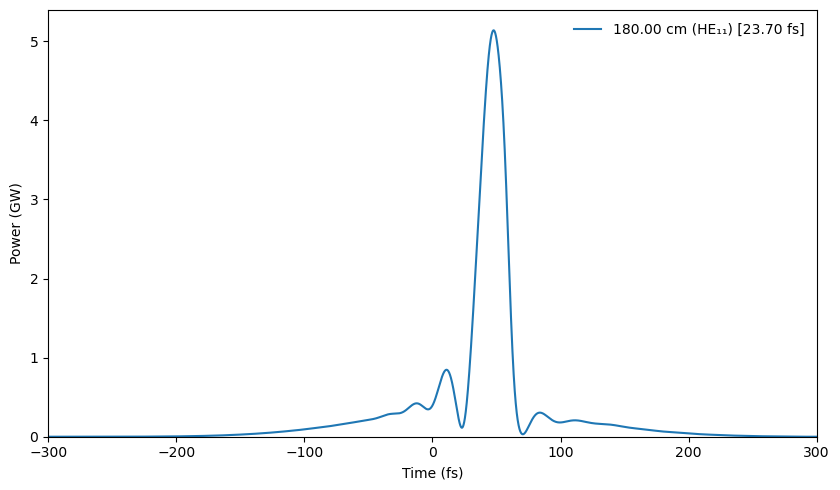

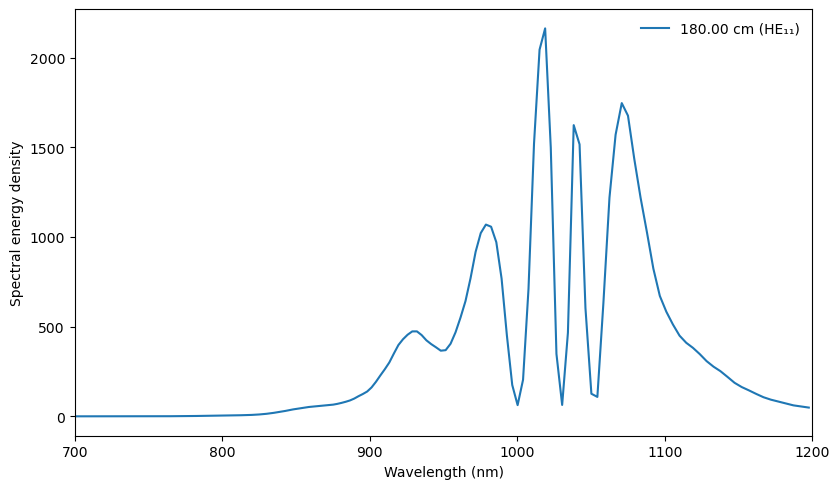

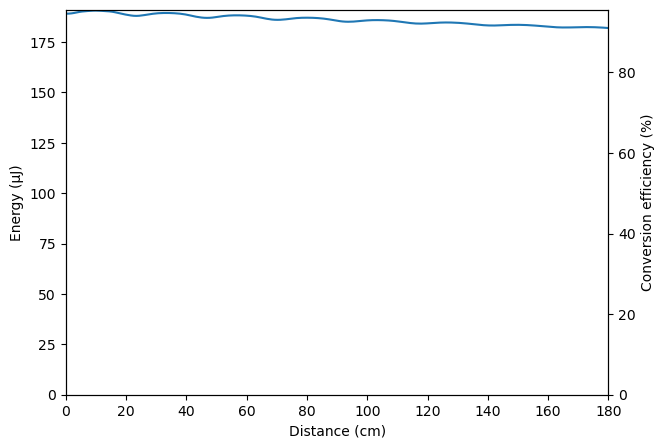

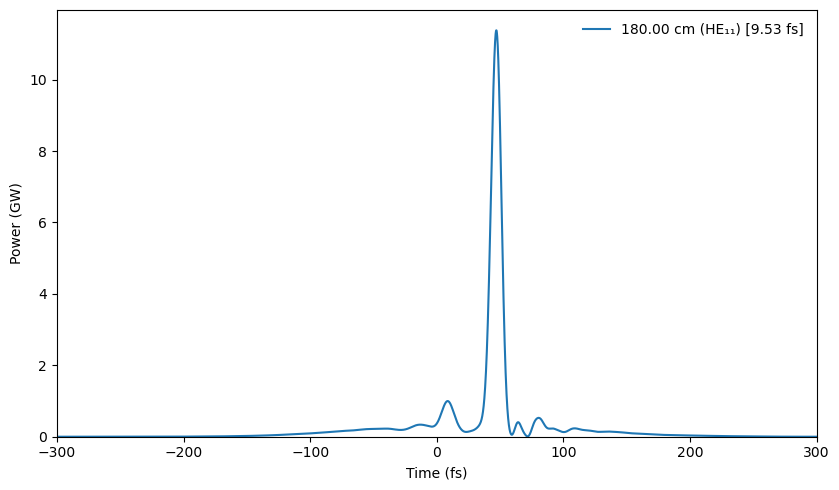

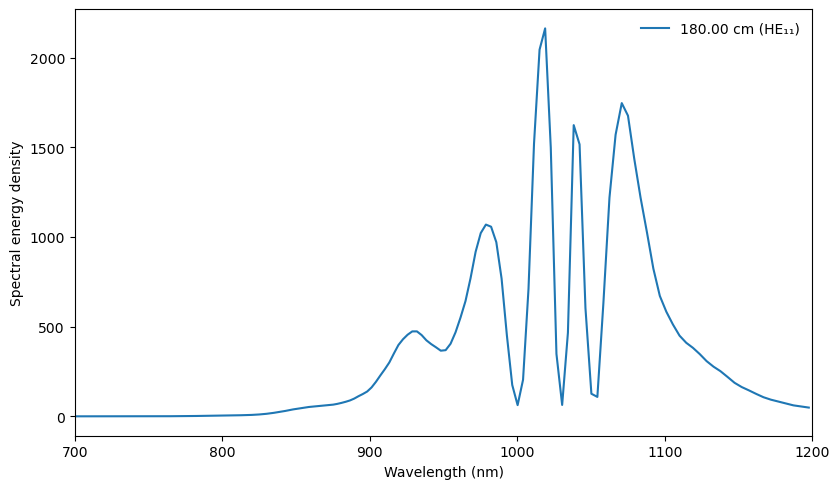

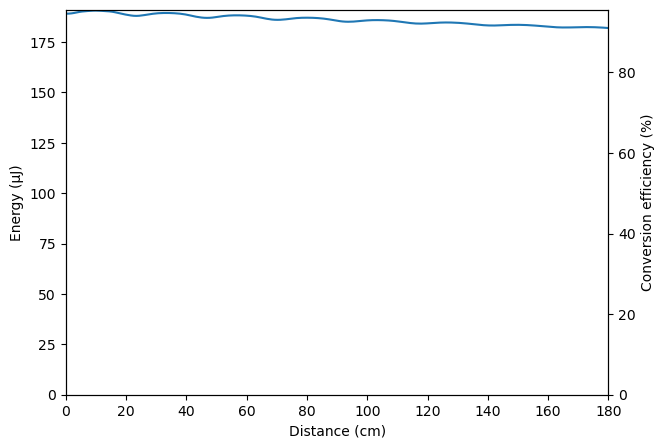

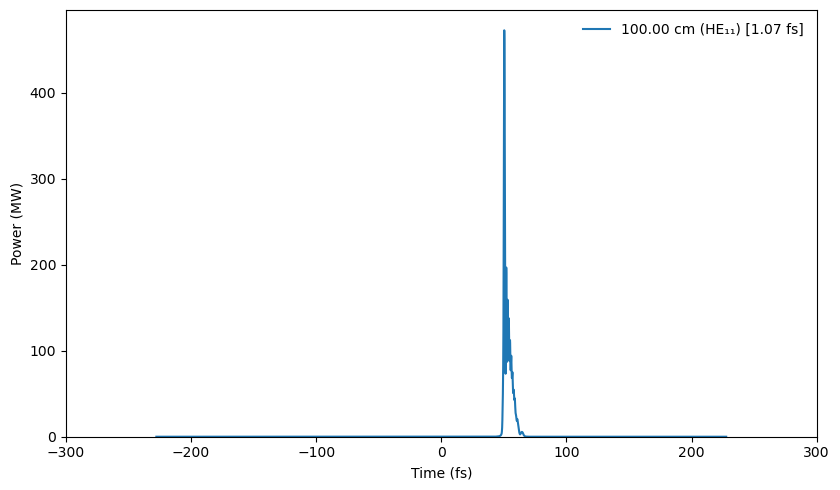

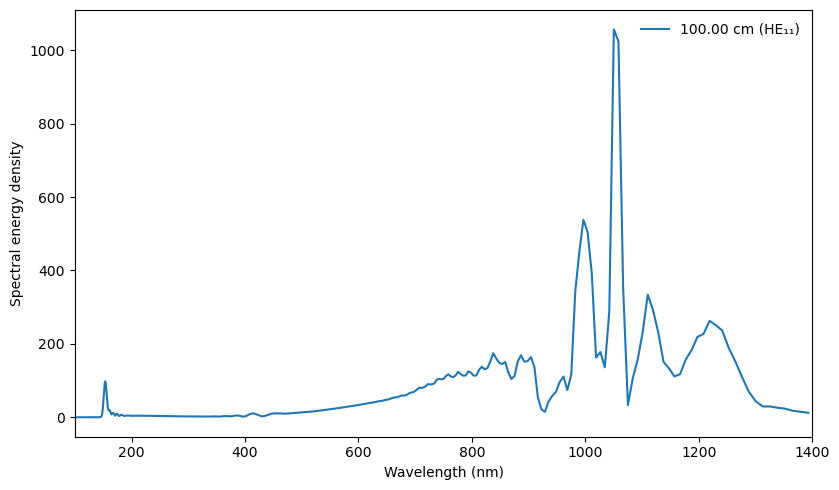

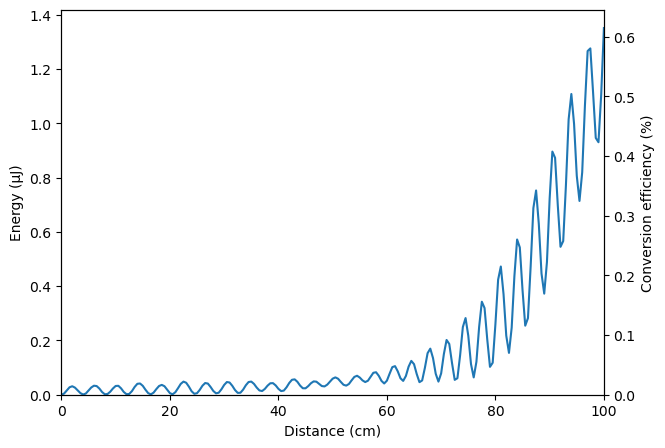

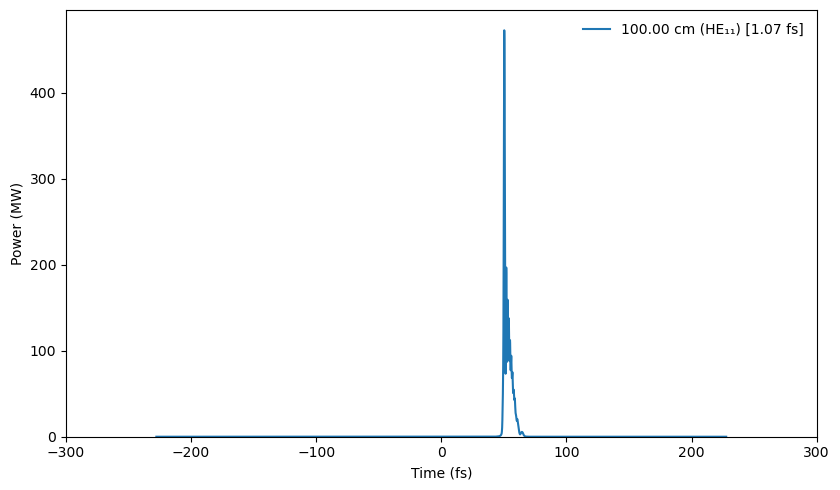

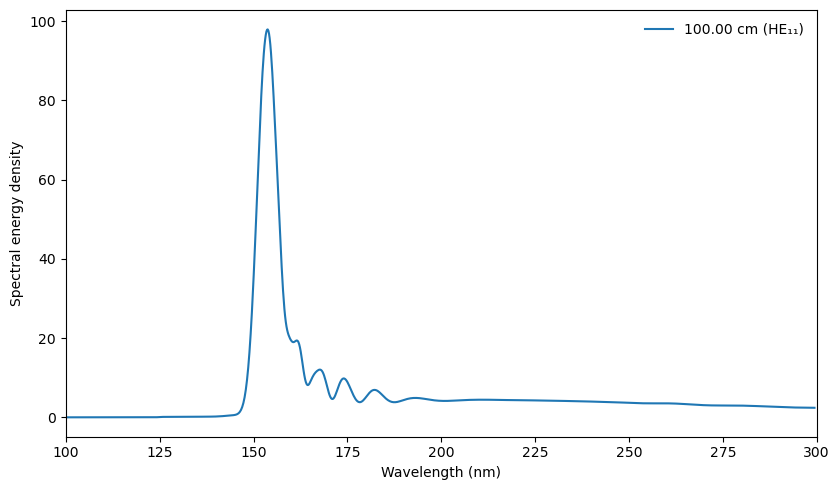

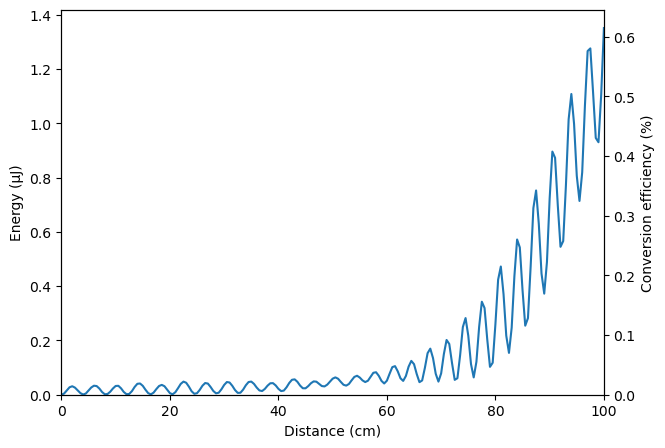

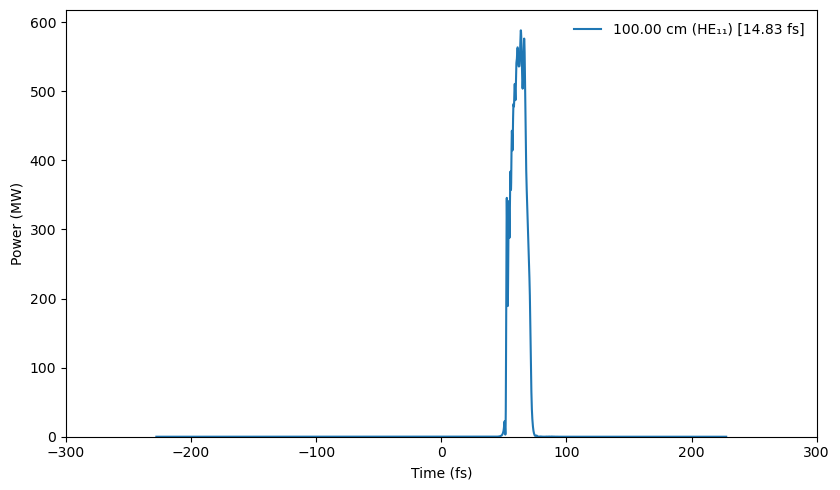

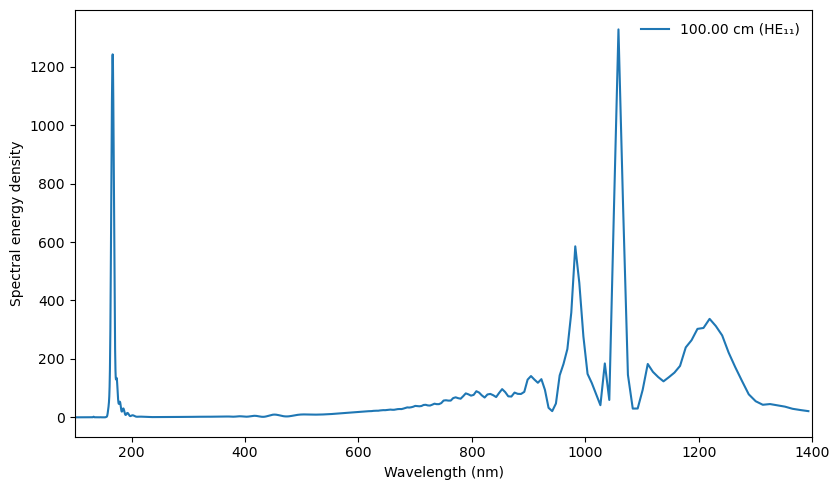

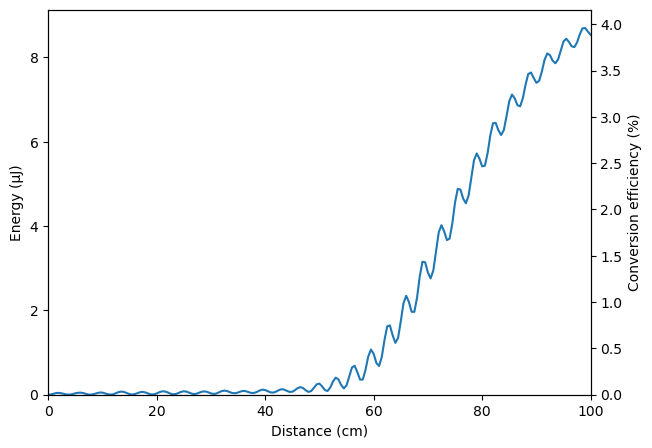

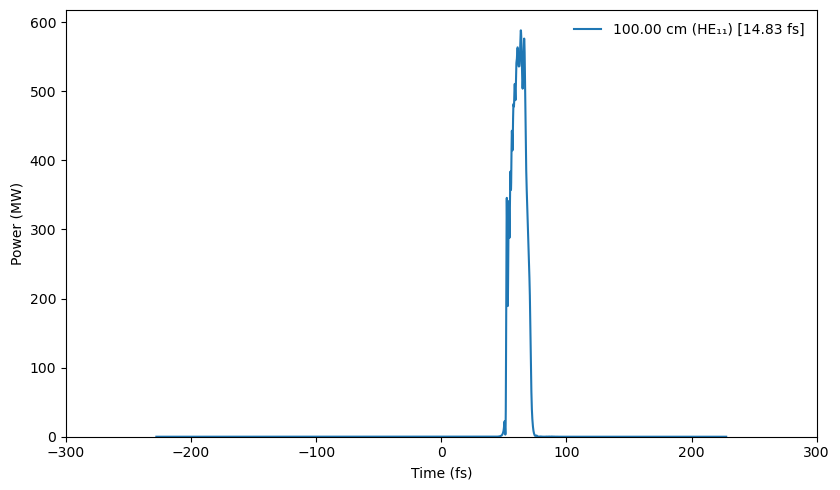

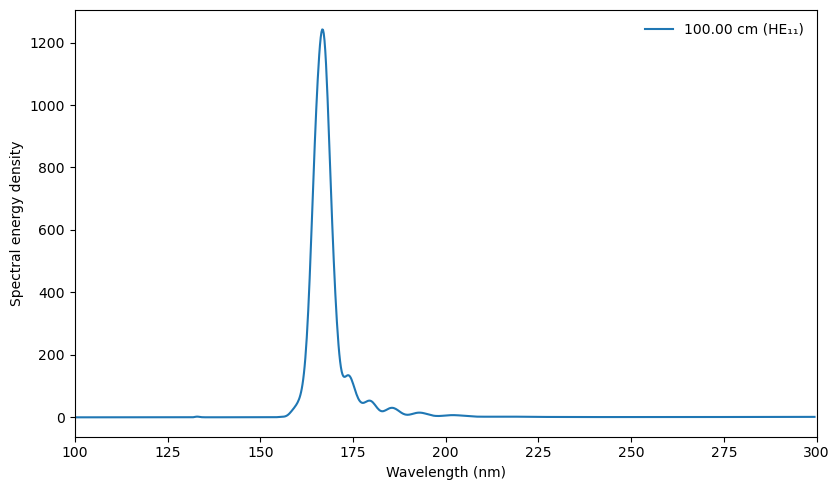

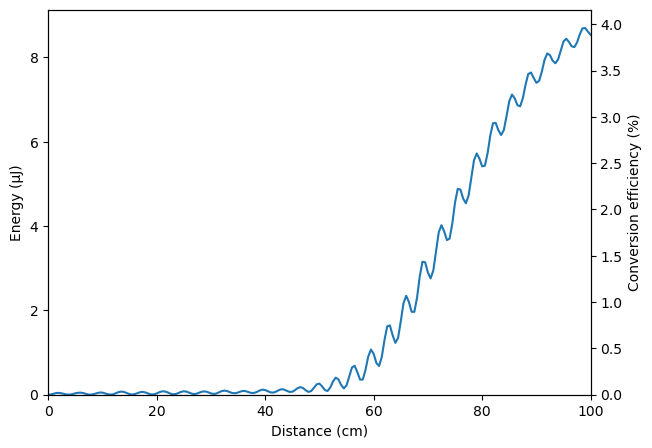

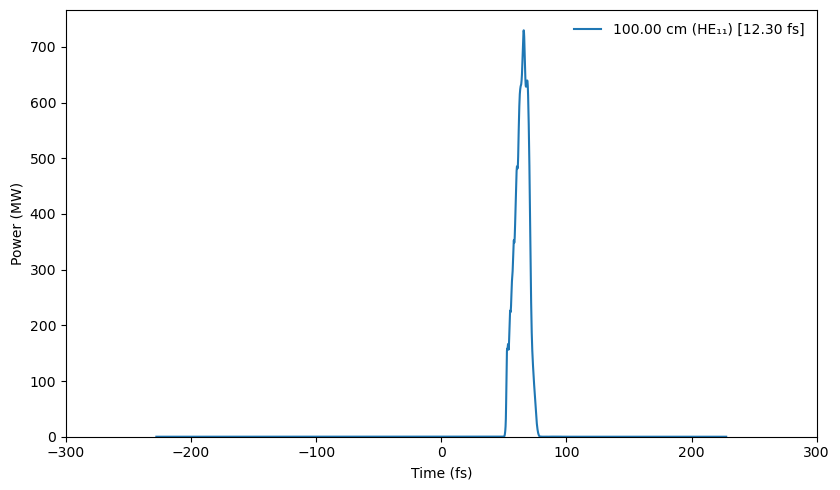

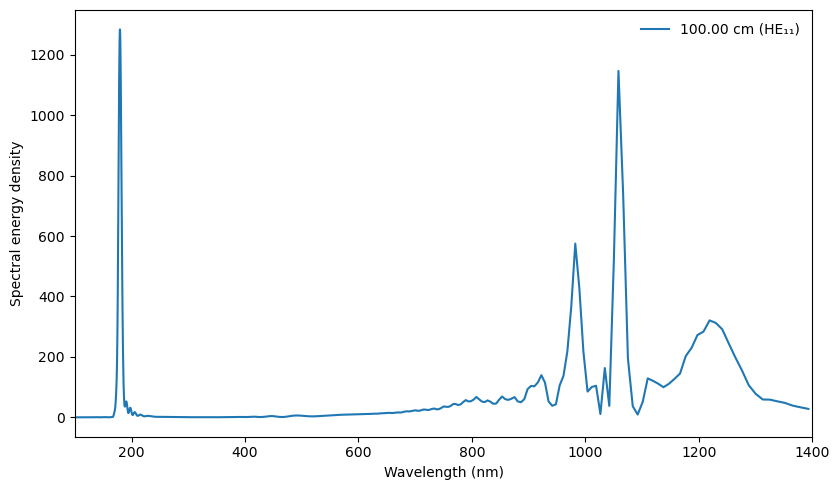

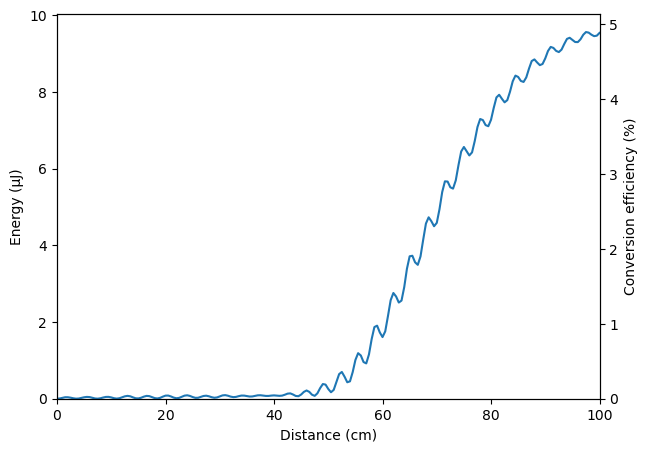

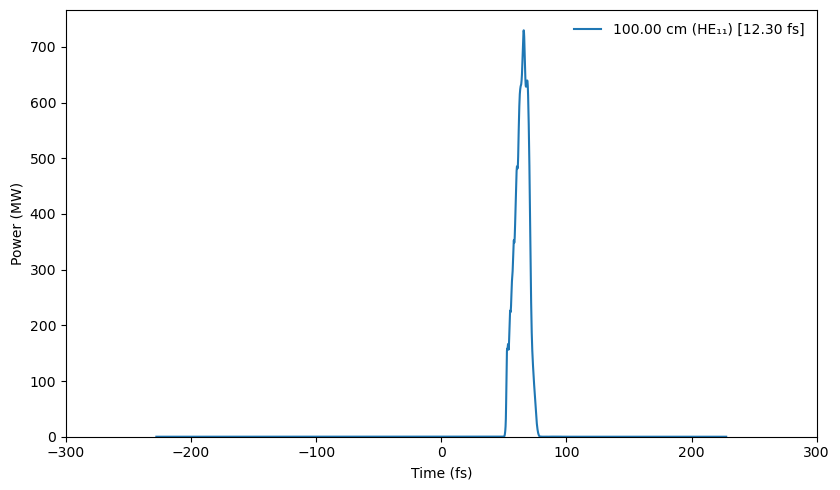

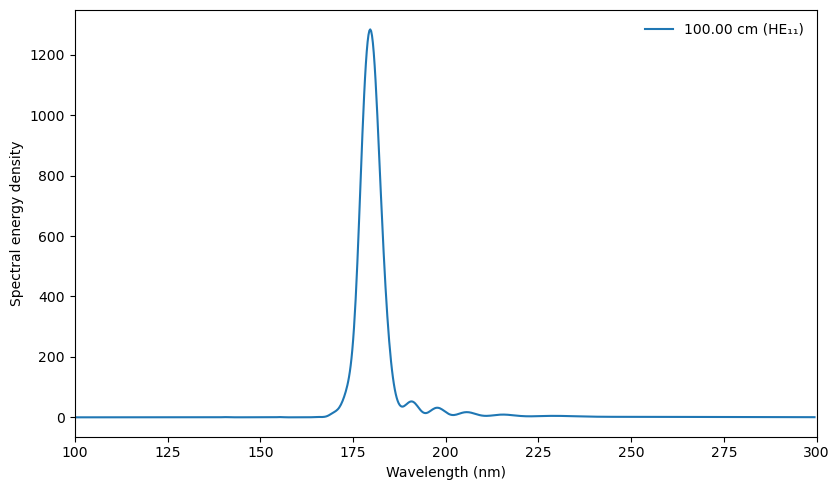

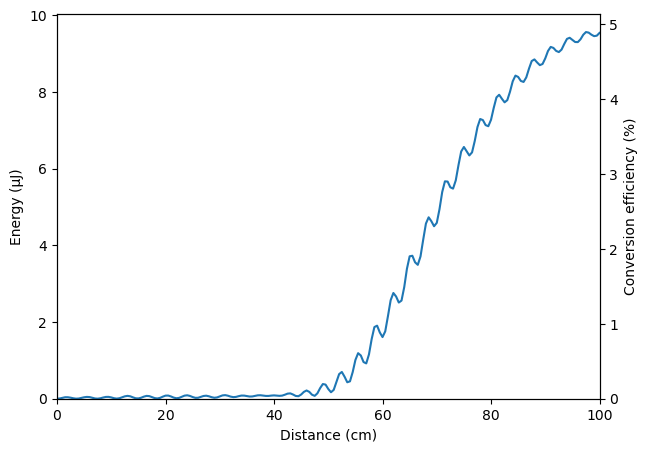

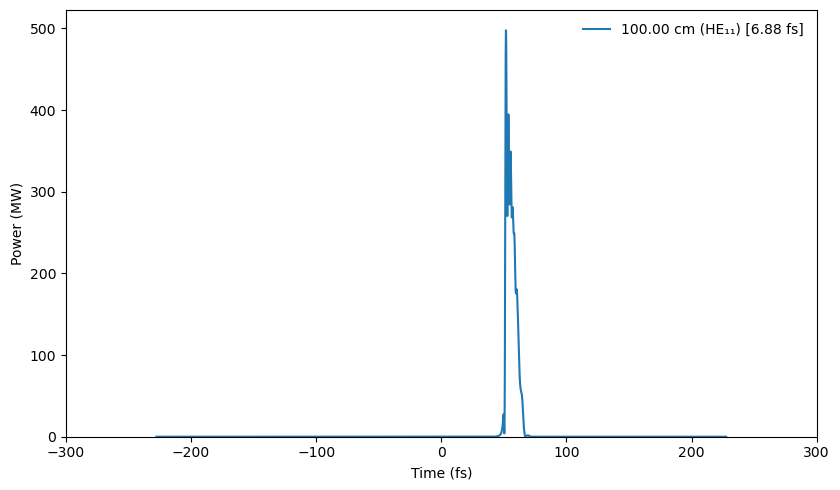

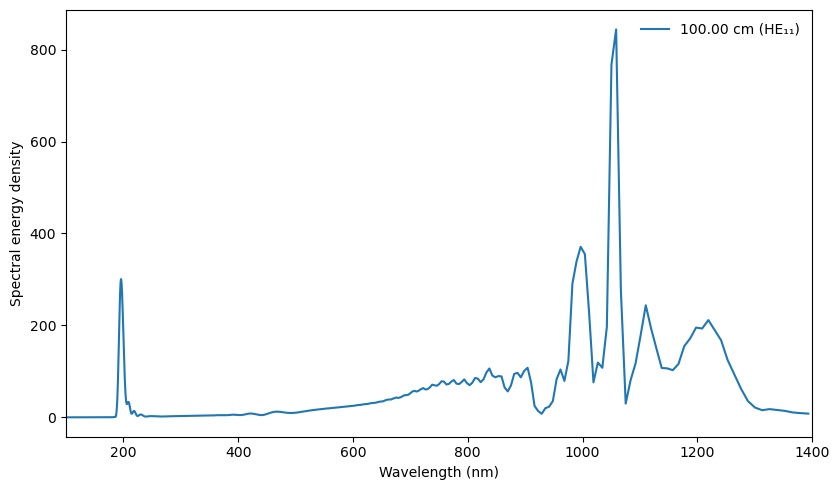

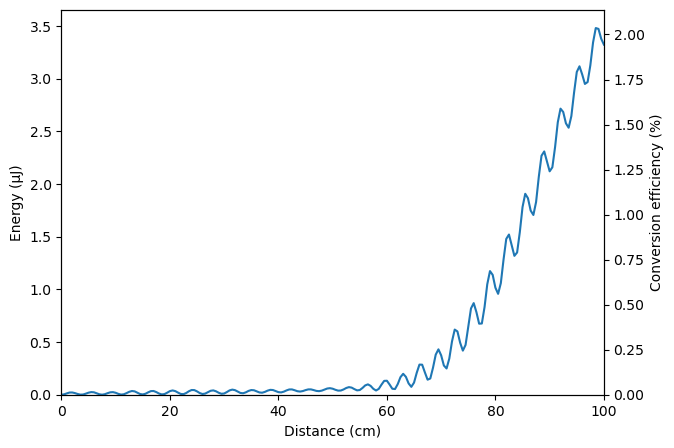

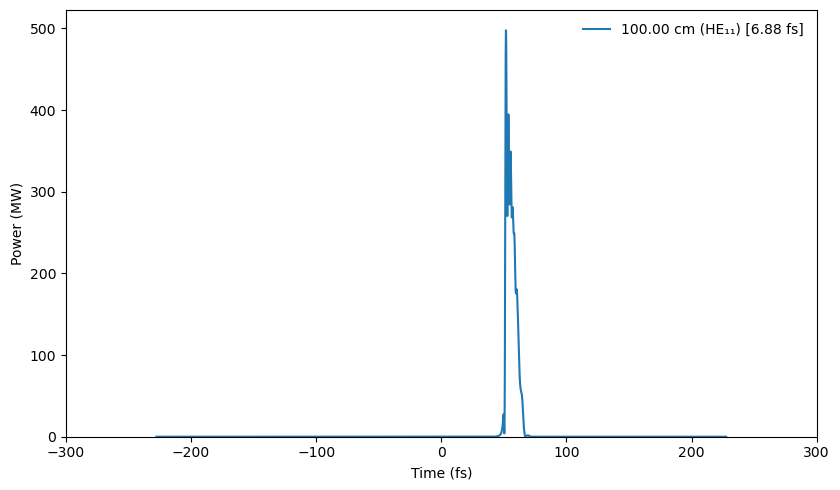

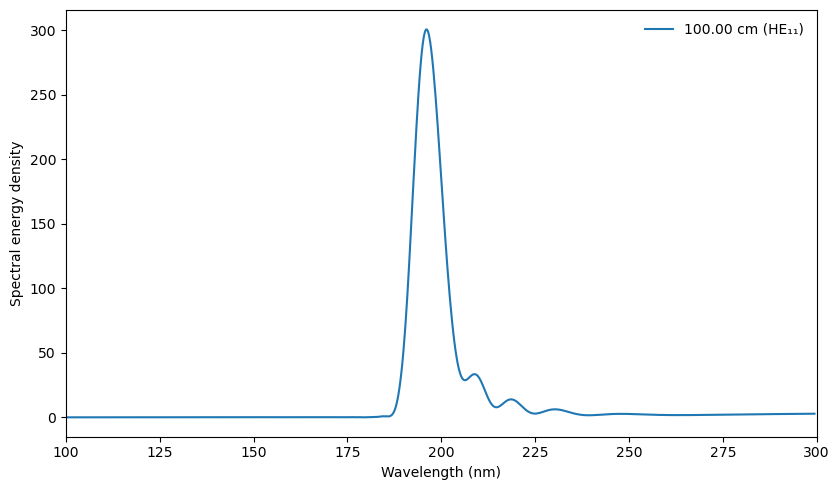

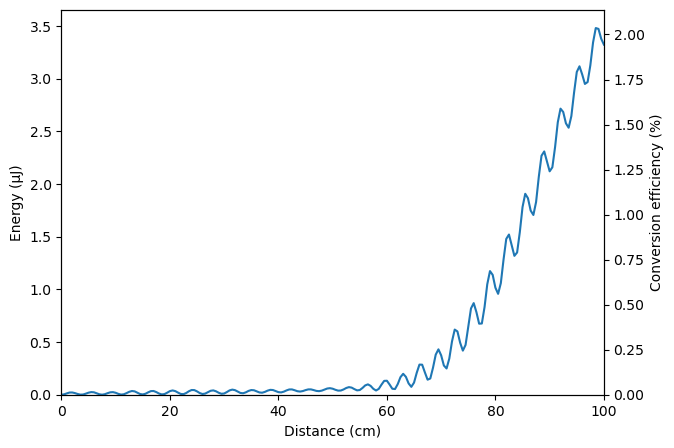

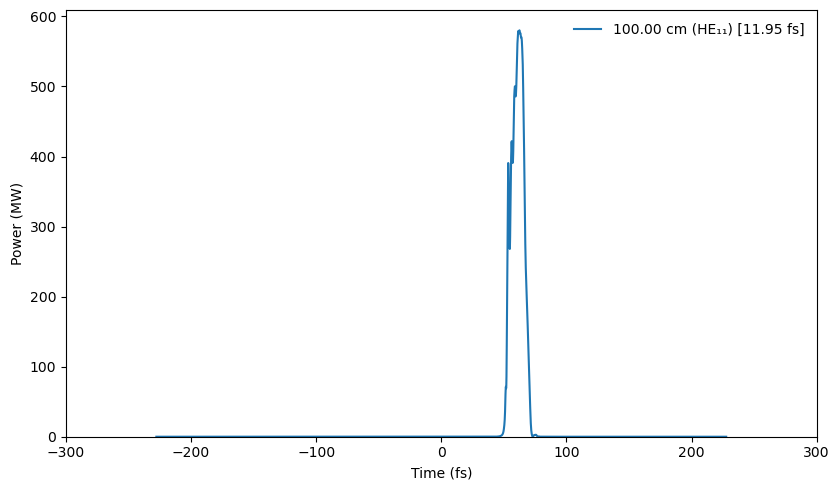

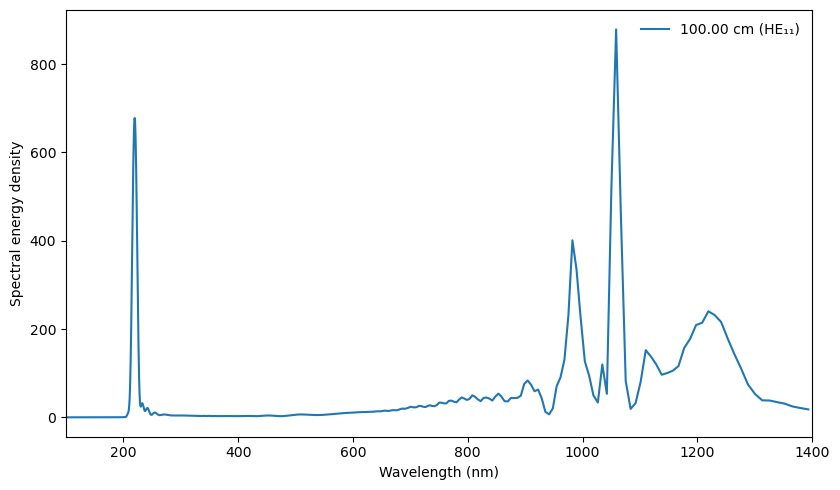

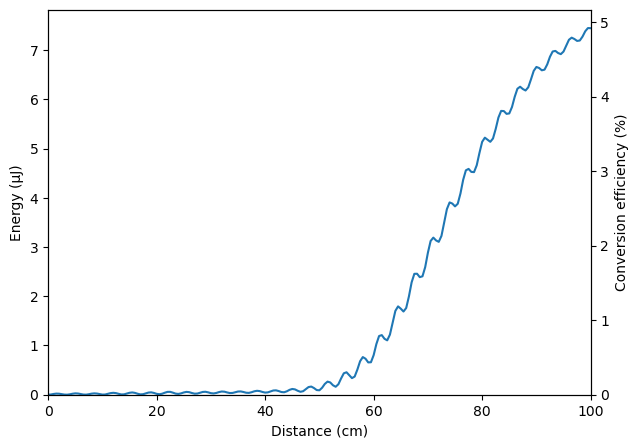

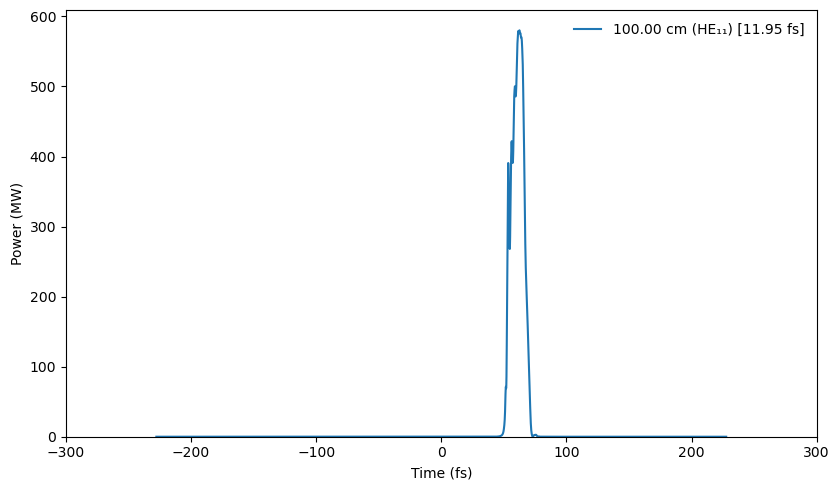

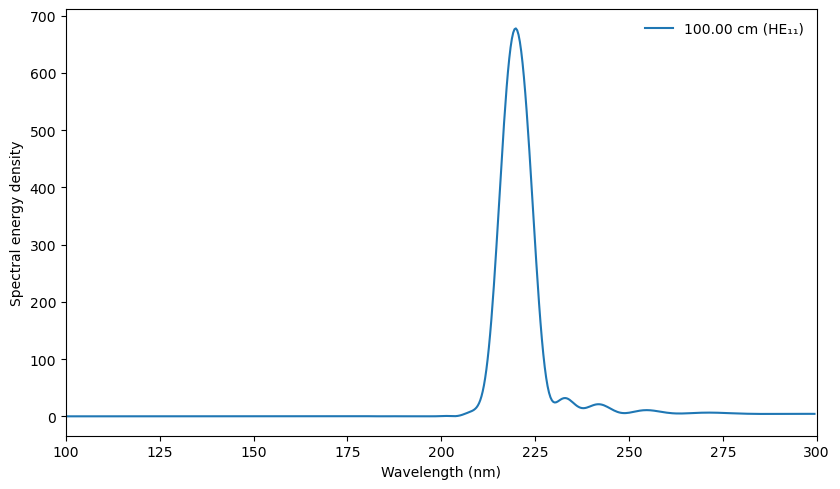

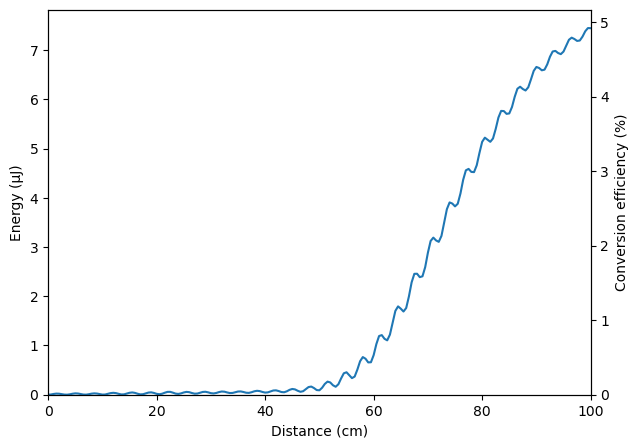

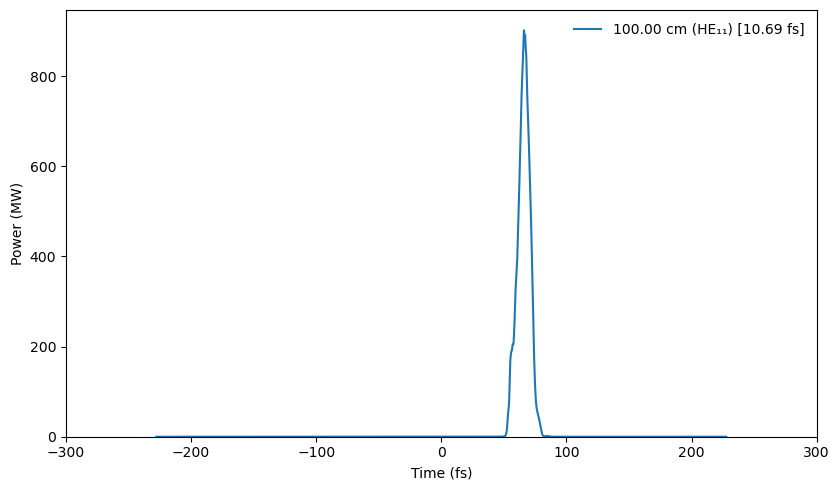

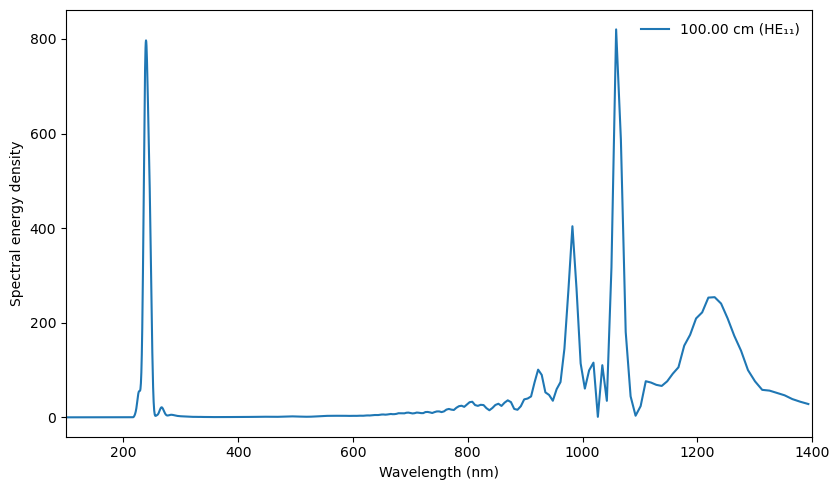

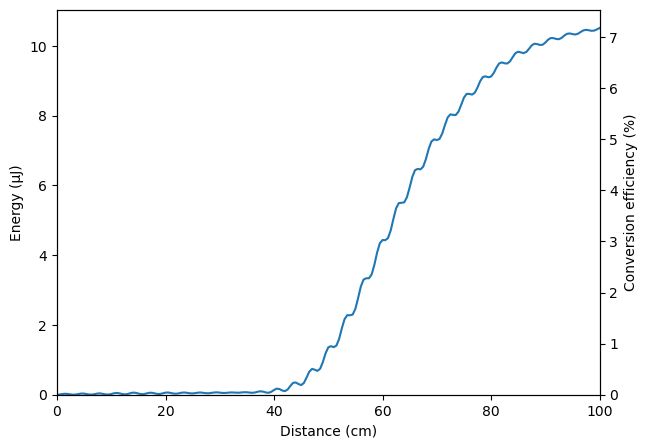

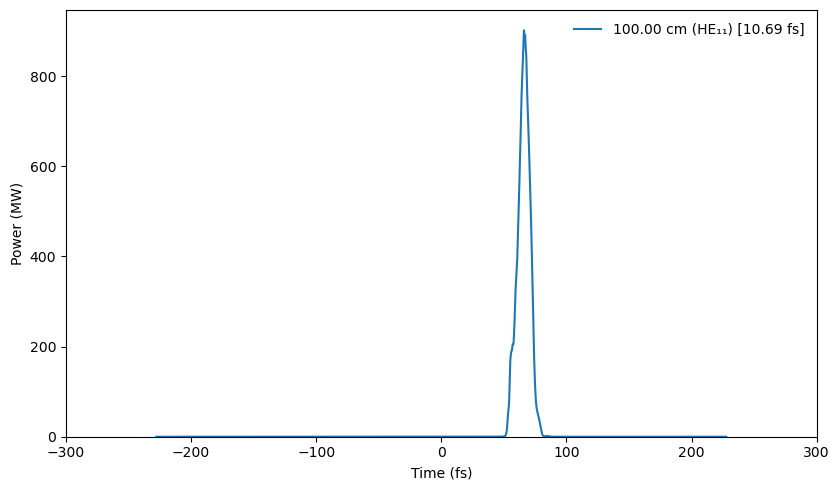

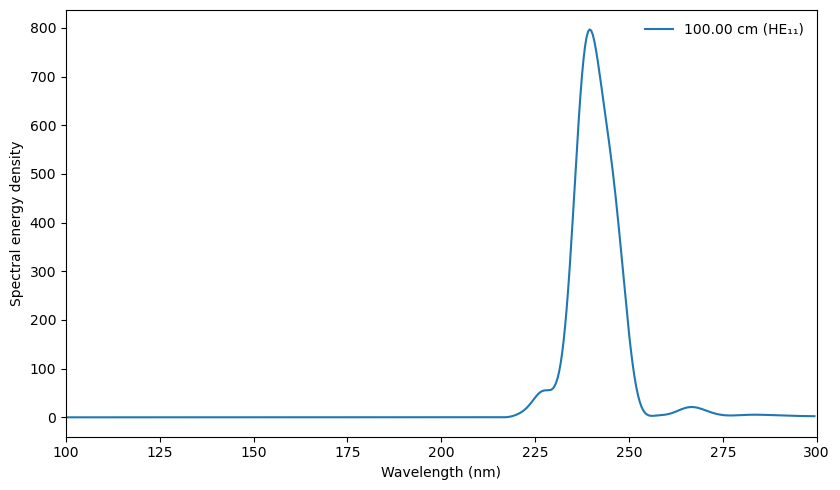

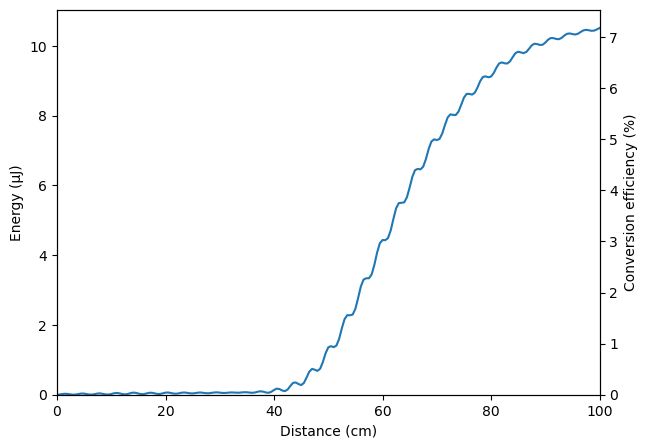

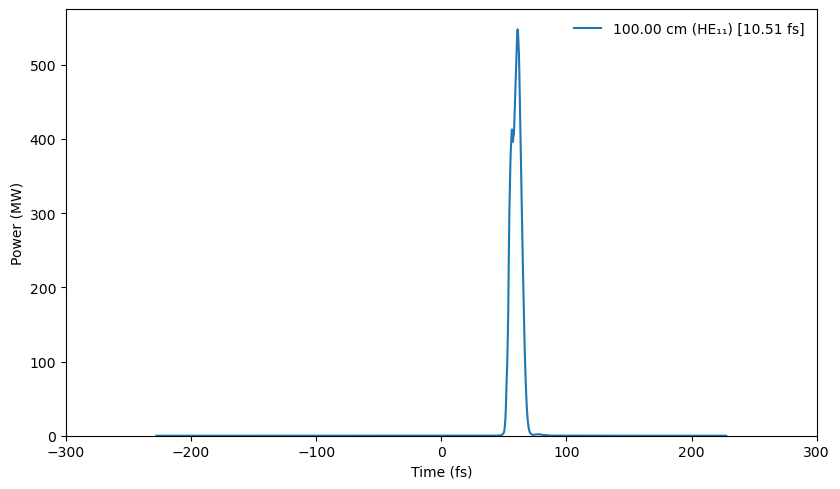

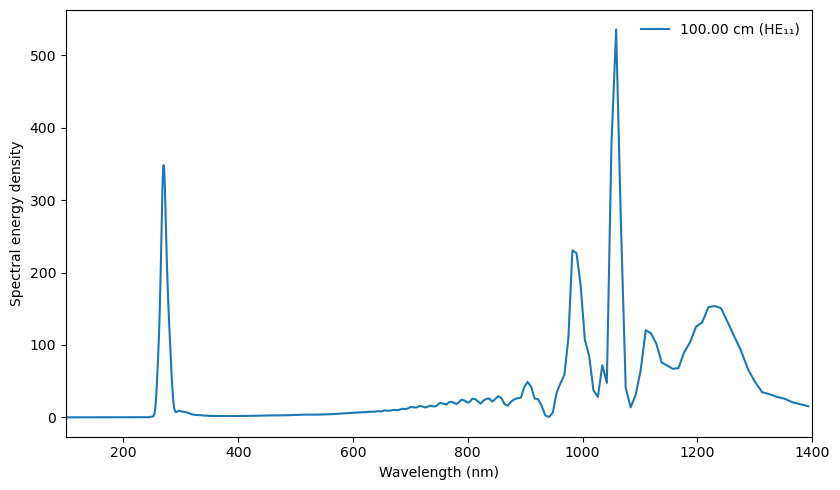

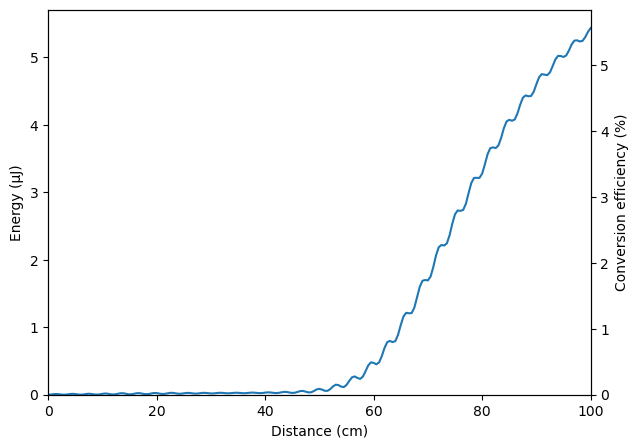

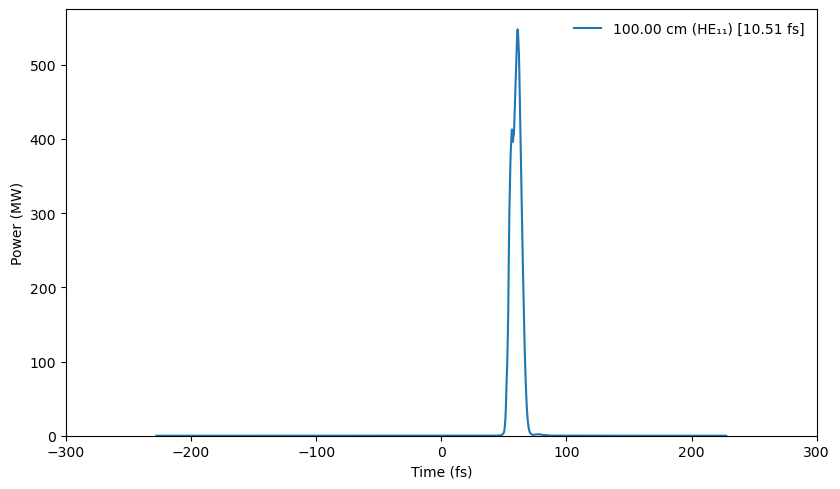

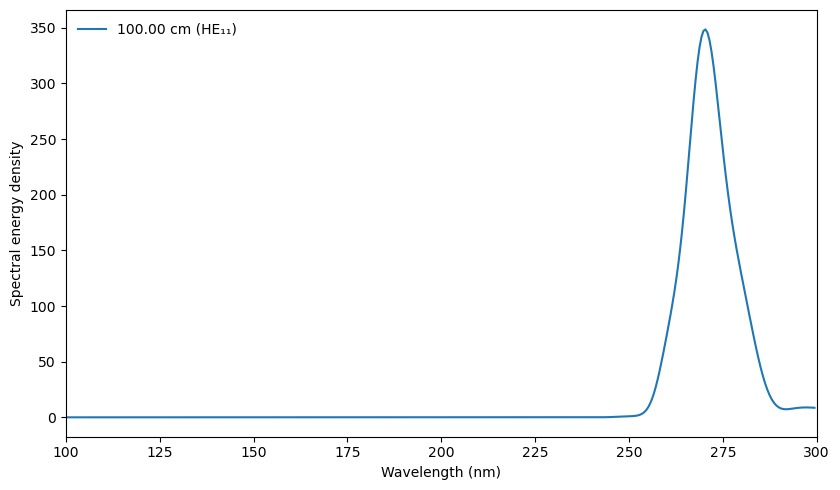

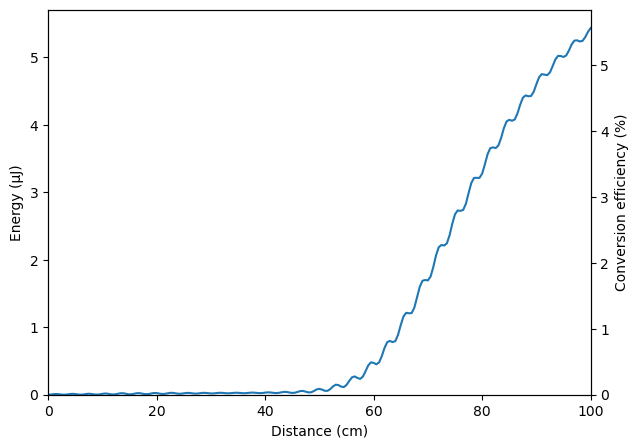

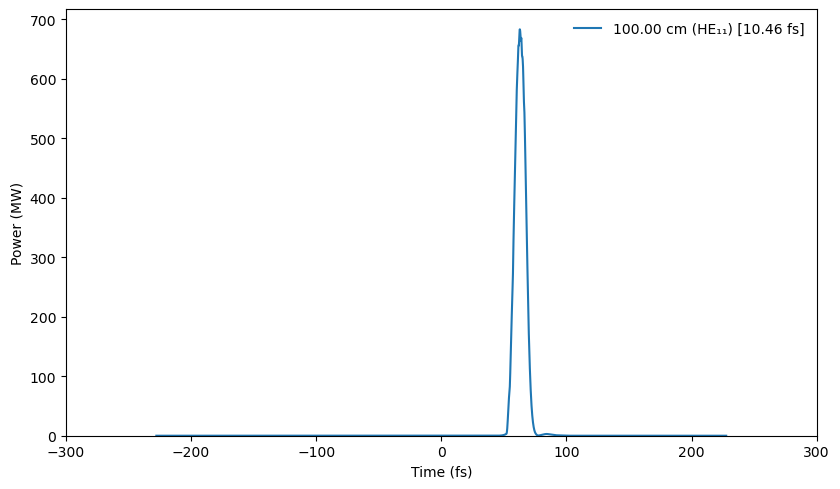

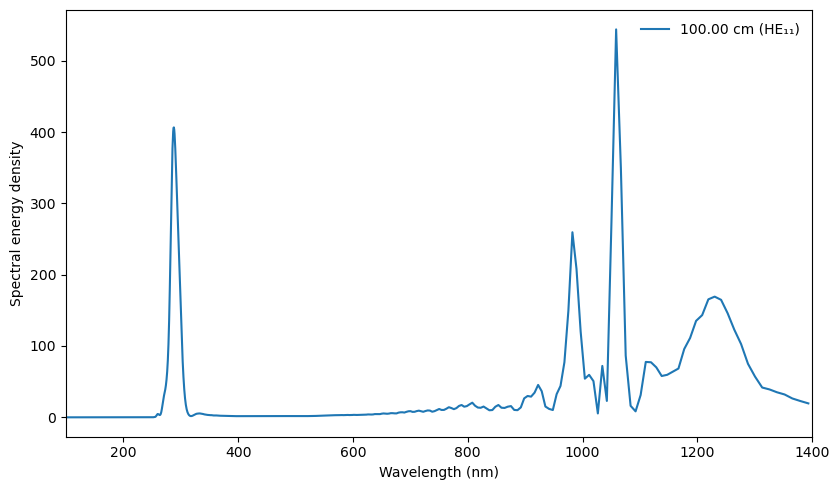

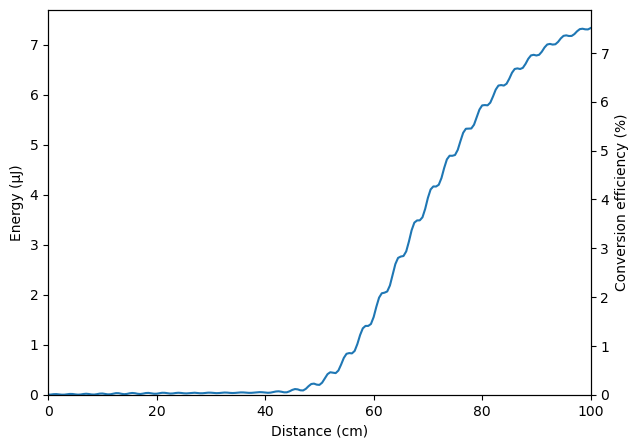

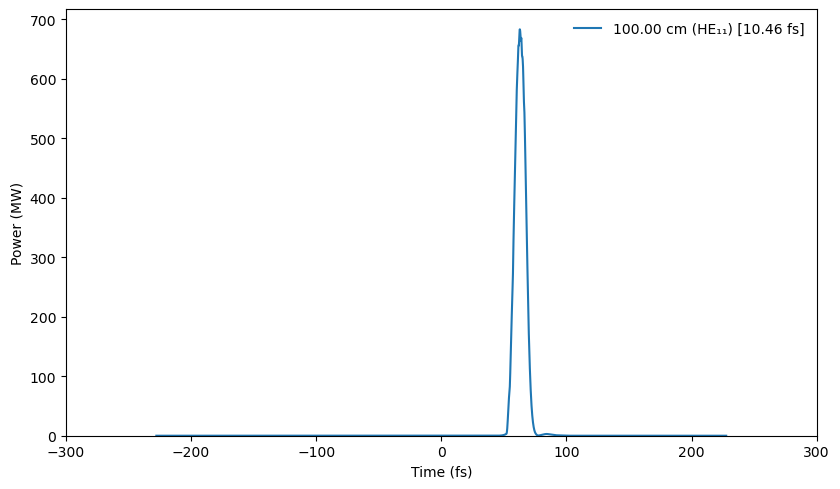

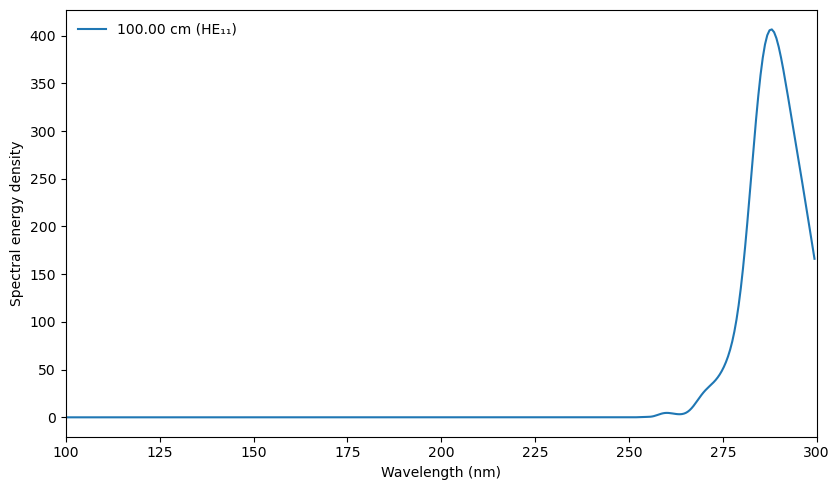

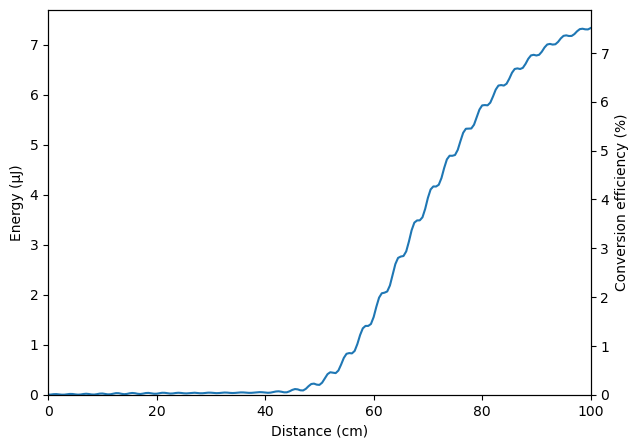

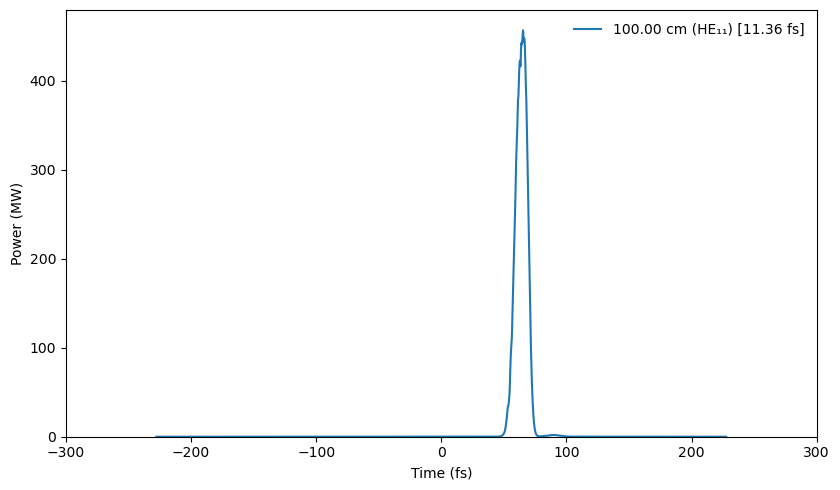

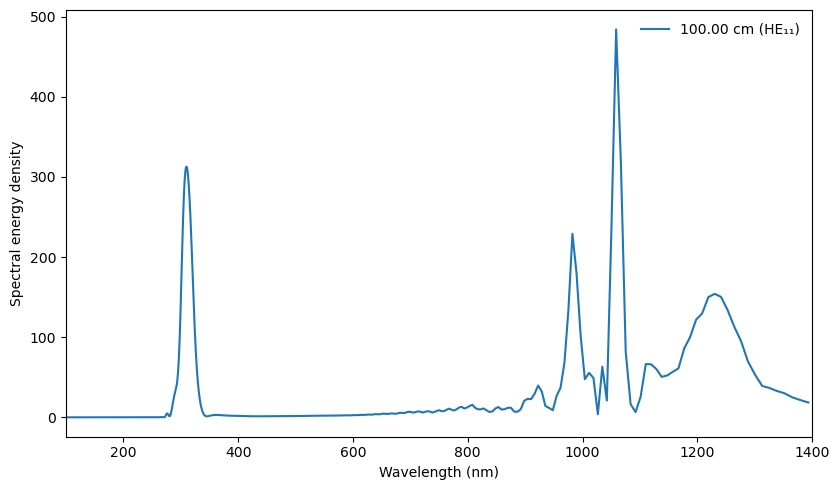

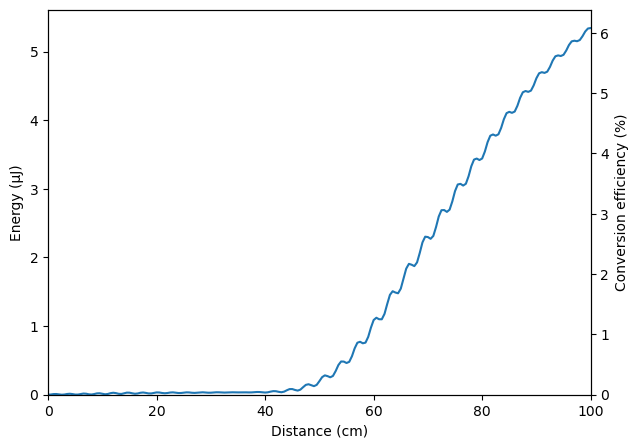

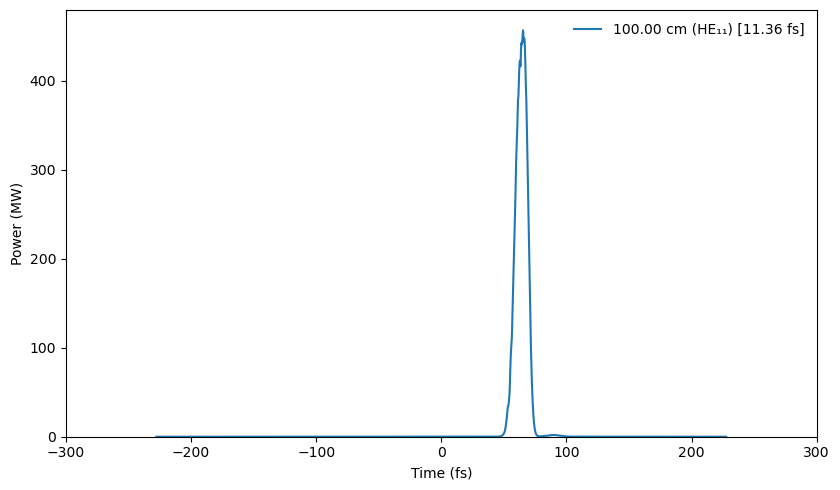

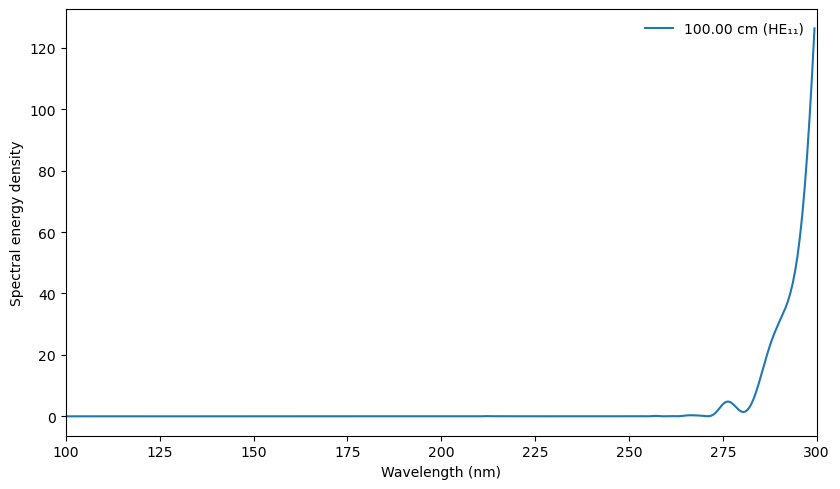

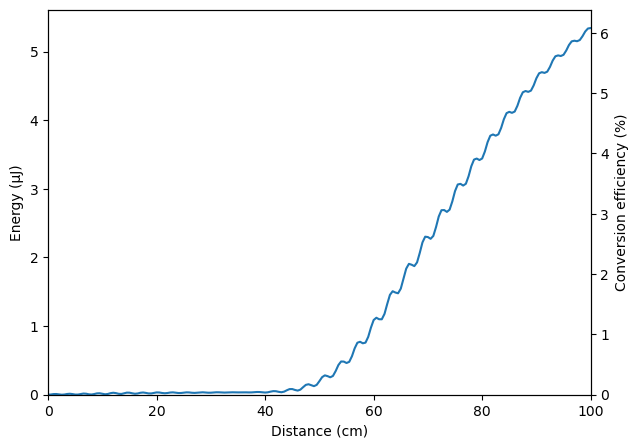

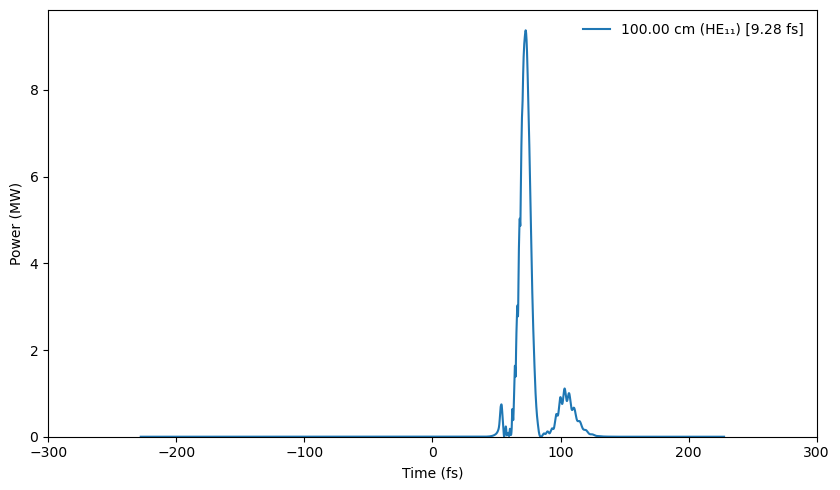

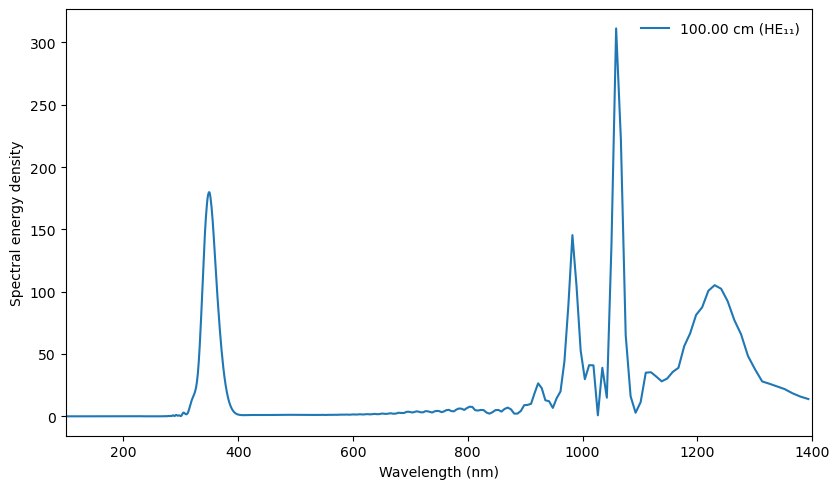

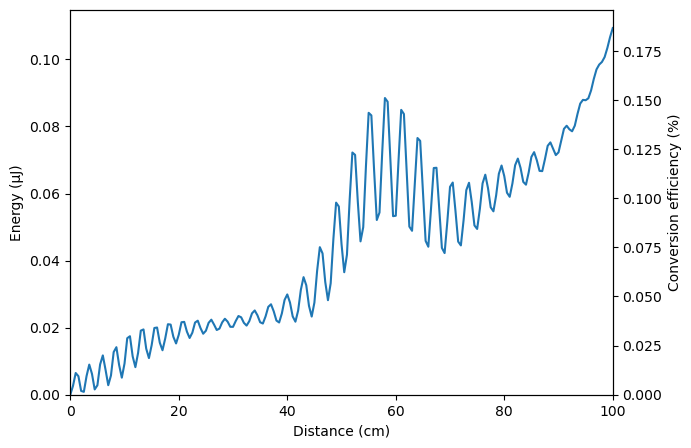

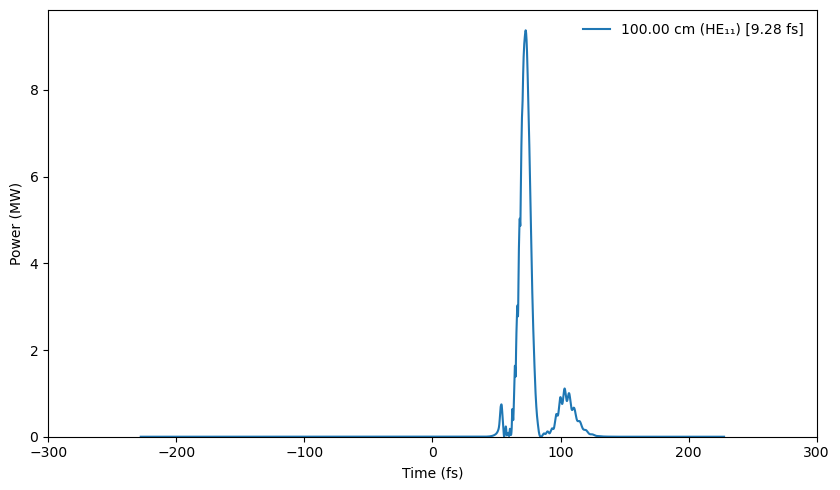

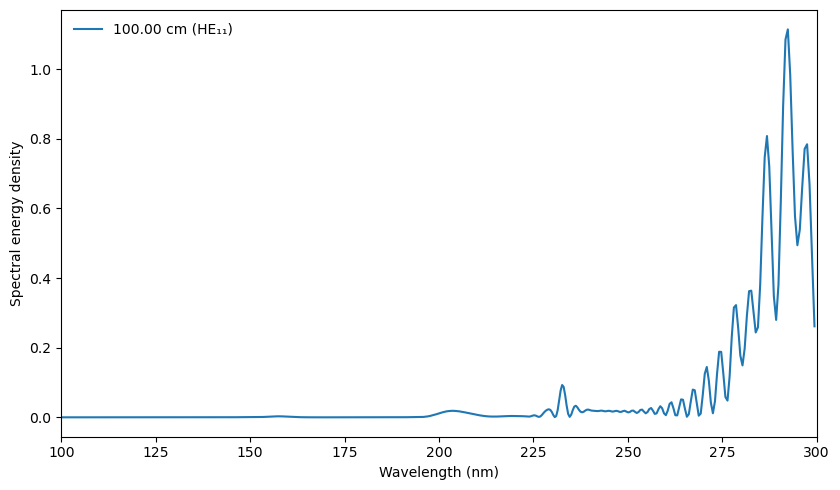

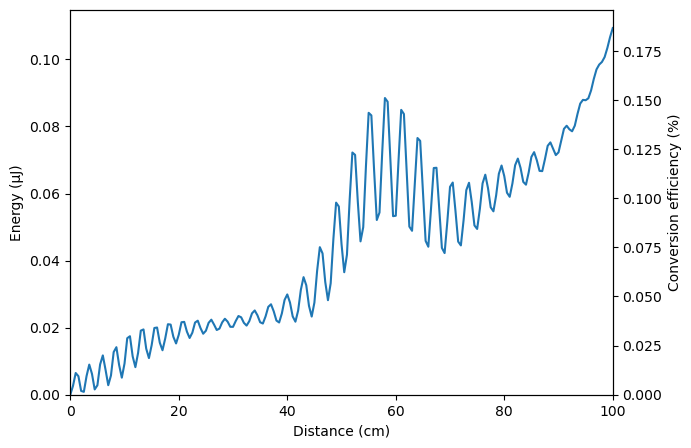

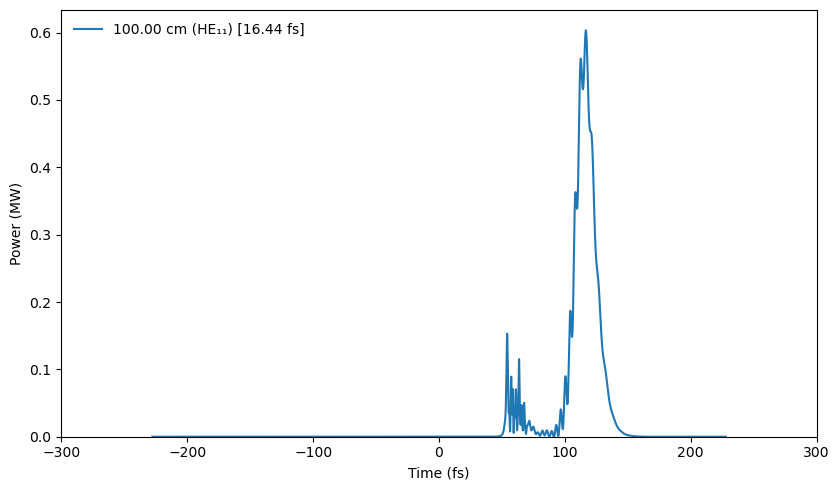

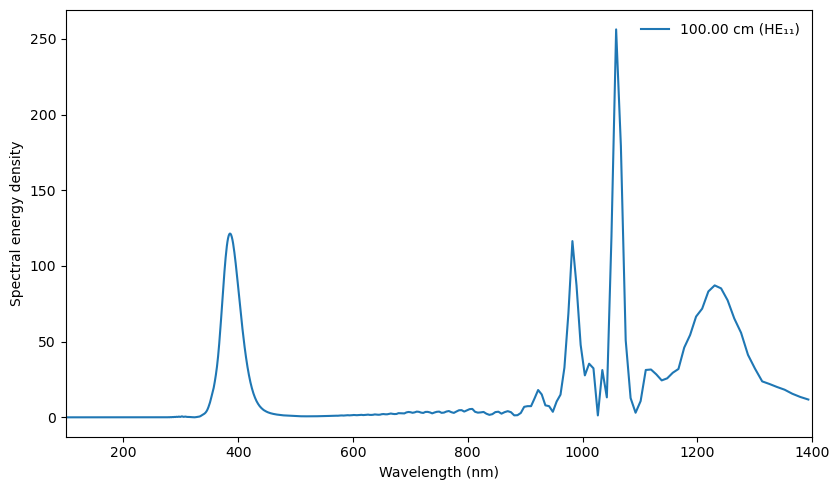

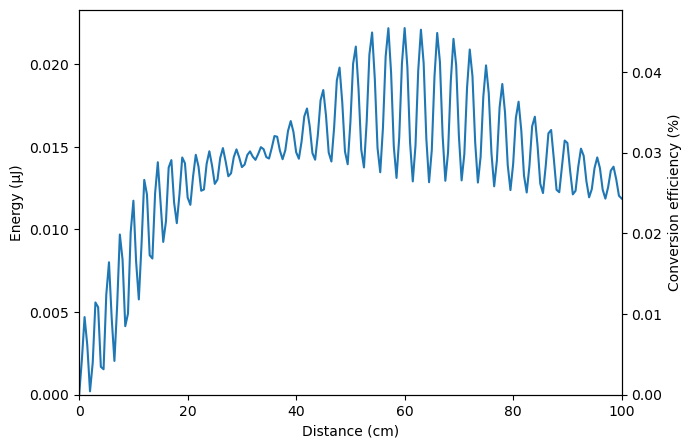

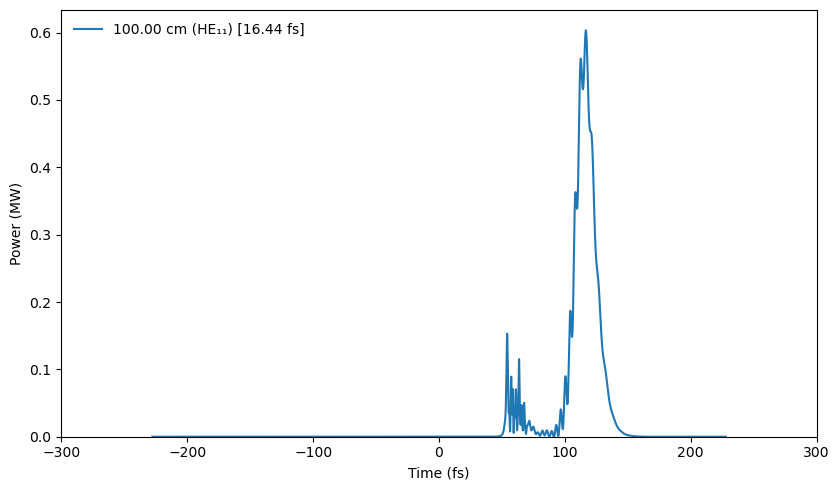

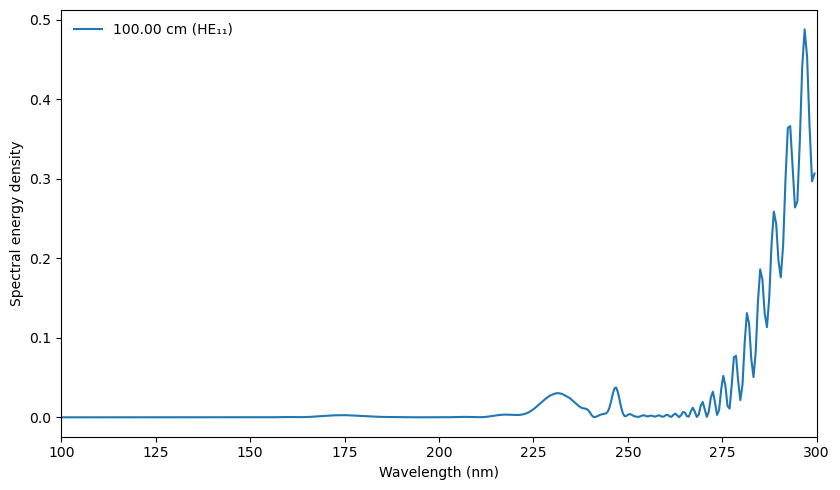

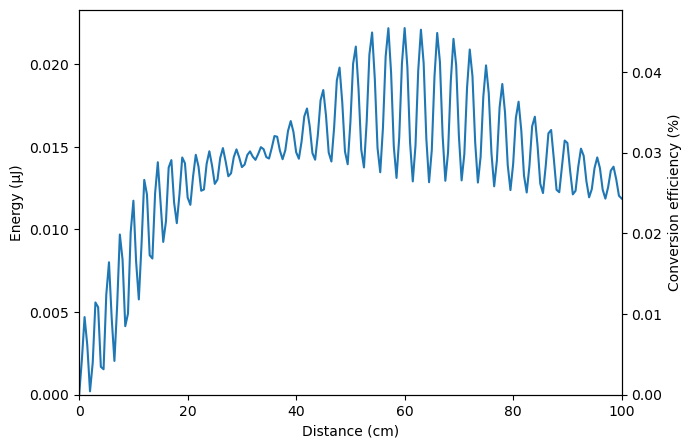

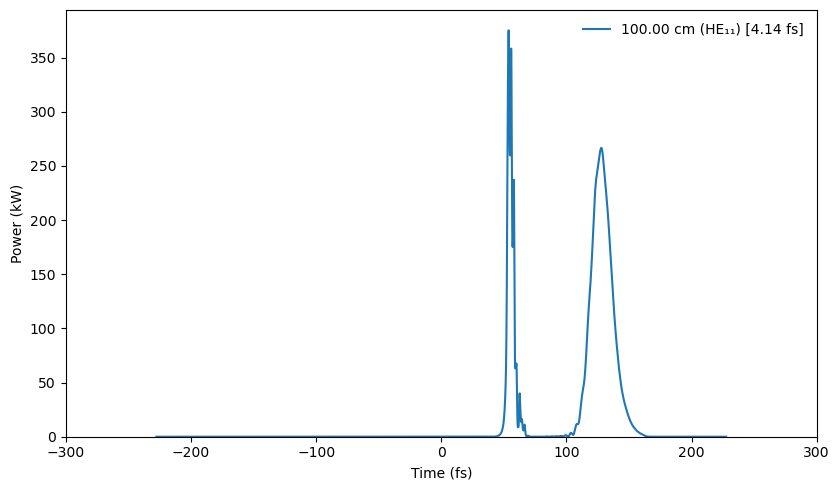

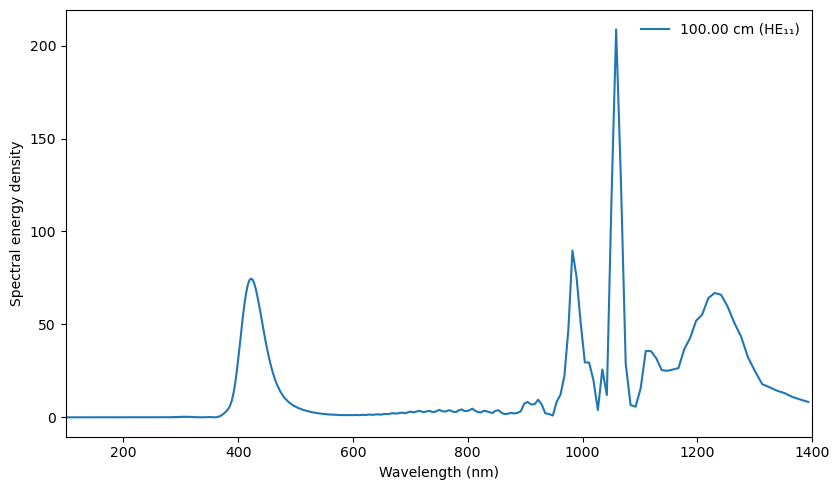

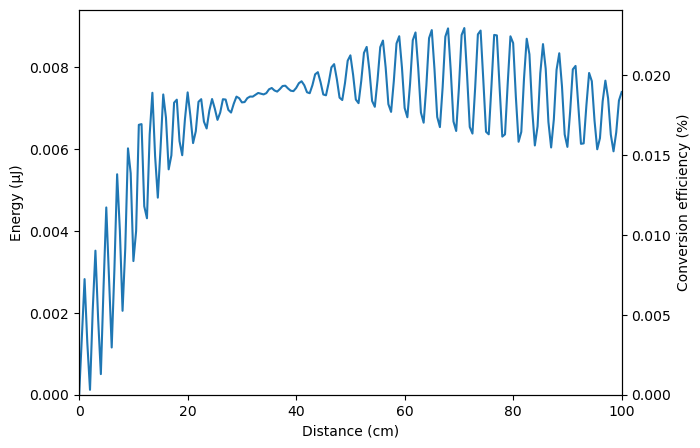

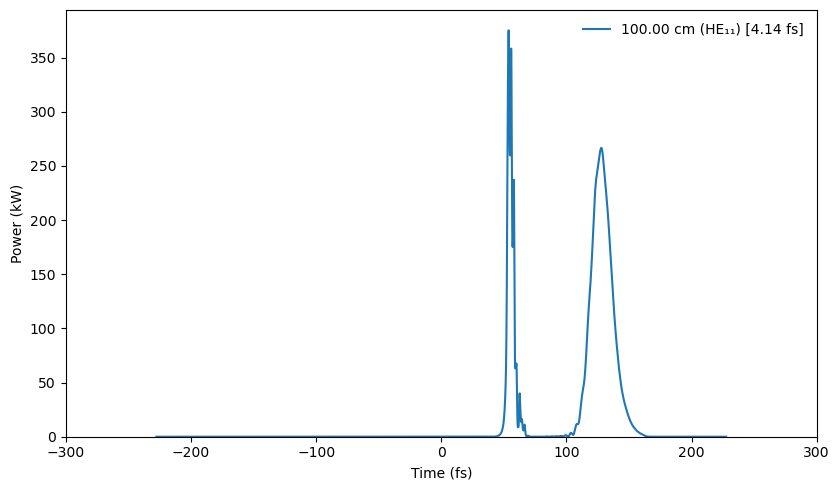

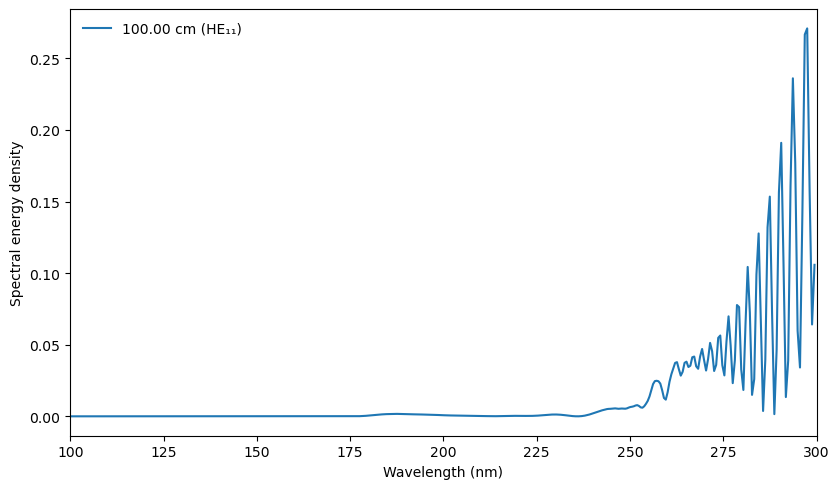

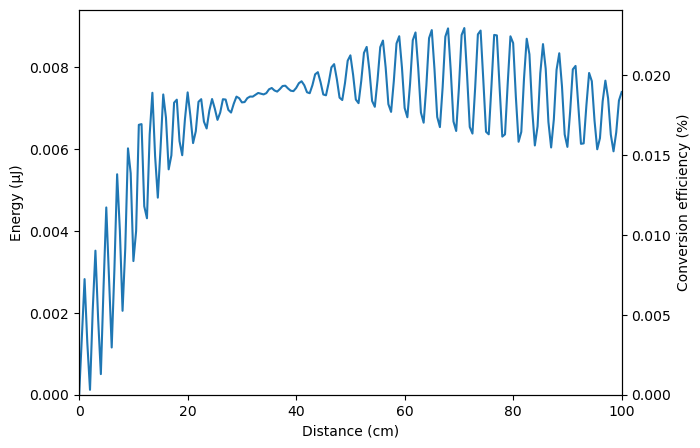

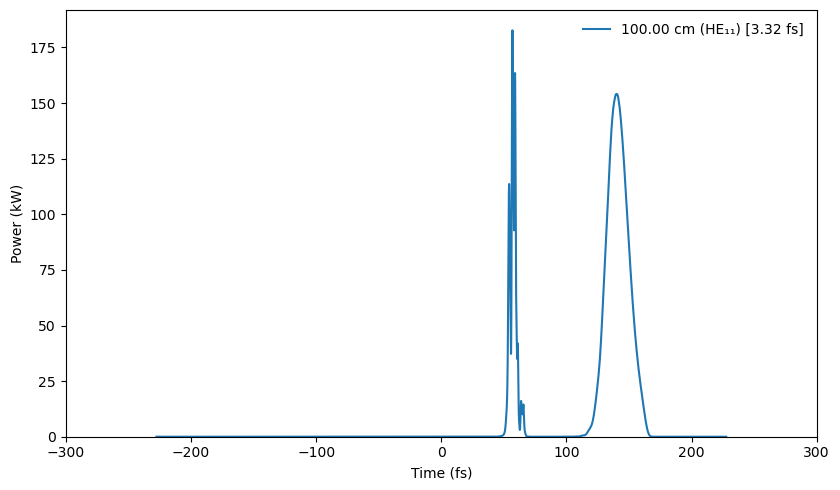

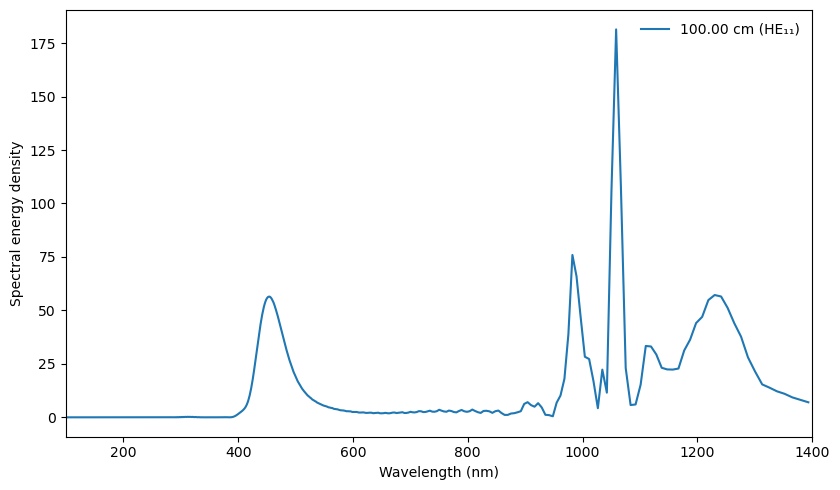

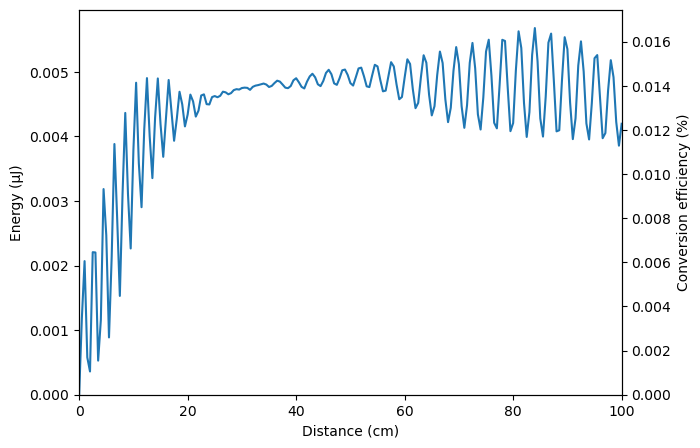

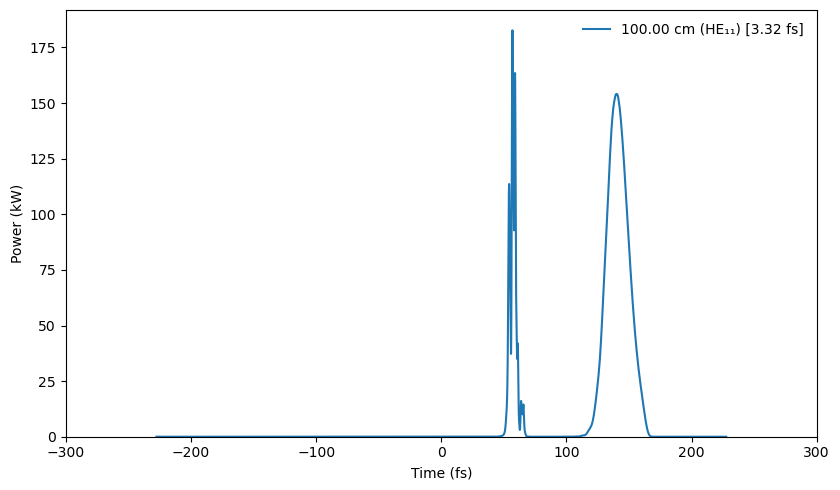

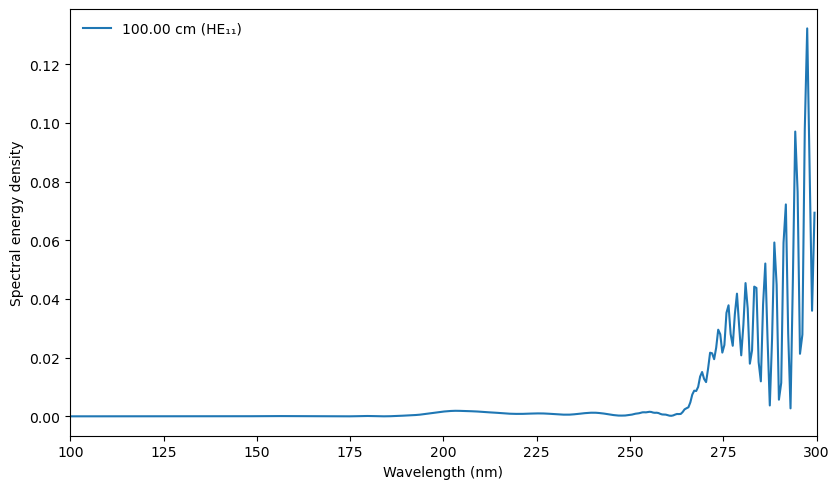

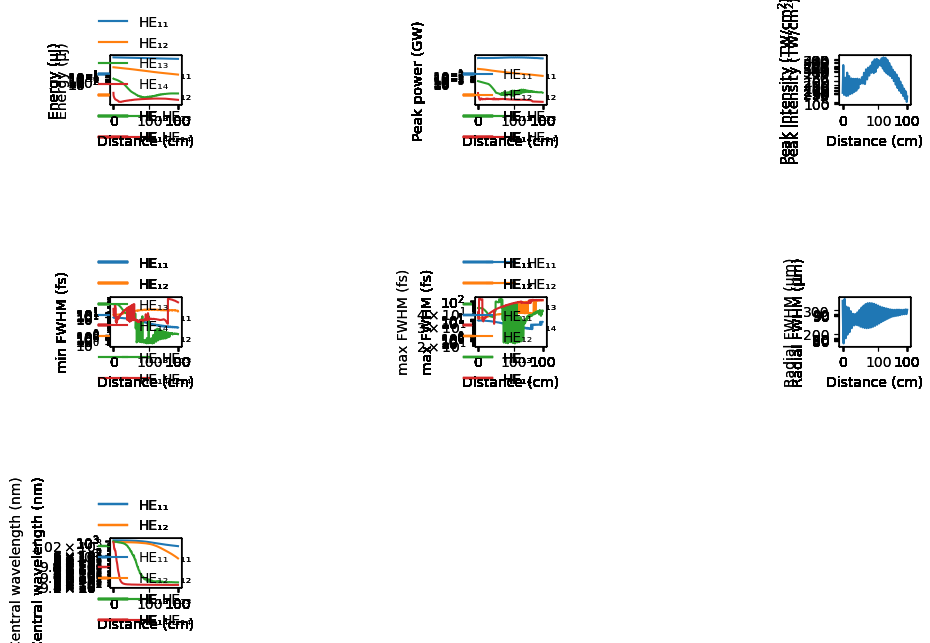

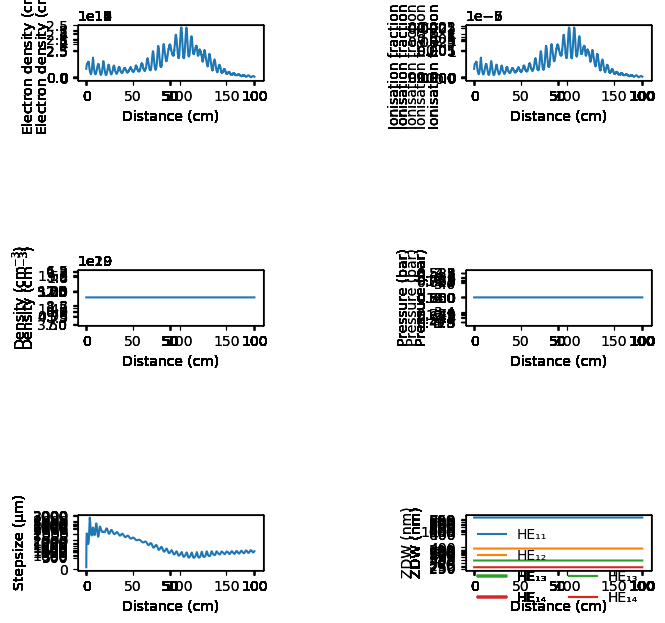

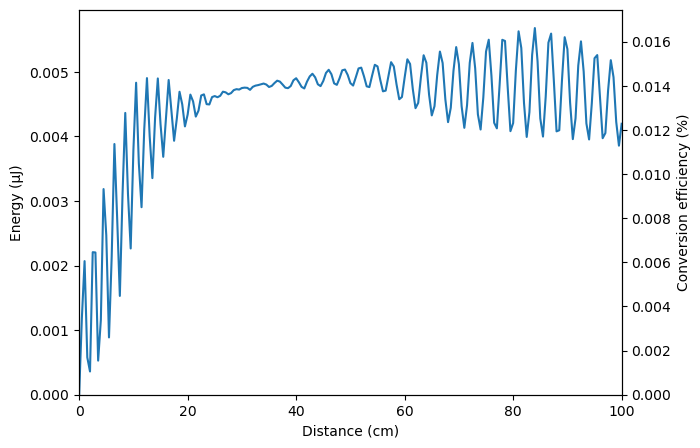

In [6]:
#:'#######::'##::: ##:'########::::::'######::'########::::'###:::::'######:::'########:
#'##.... ##: ###:: ##: ##.... ##::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#..::::: ##: ####: ##: ##:::: ##:::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#:'#######:: ## ## ##: ##:::: ##::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#'##:::::::: ##. ####: ##:::: ##:::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
# ##:::::::: ##:. ###: ##:::: ##::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
# #########: ##::. ##: ########:::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#.........::..::::..::........:::::::......::::::..:::::..:::::..:::......::::........::

#:'#######::'########::'########::::::'######::'########::::'###:::::'######:::'########:
#'##.... ##: ##.... ##: ##.... ##::::'##... ##:... ##..::::'## ##:::'##... ##:: ##.....::
#..::::: ##: ##:::: ##: ##:::: ##:::: ##:::..::::: ##:::::'##:. ##:: ##:::..::: ##:::::::
#:'#######:: ########:: ##:::: ##::::. ######::::: ##::::'##:::. ##: ##::'####: ######:::
#:...... ##: ##.. ##::: ##:::: ##:::::..... ##:::: ##:::: #########: ##::: ##:: ##...::::
#'##:::: ##: ##::. ##:: ##:::: ##::::'##::: ##:::: ##:::: ##.... ##: ##::: ##:: ##:::::::
#. #######:: ##:::. ##: ########:::::. ######::::: ##:::: ##:::: ##:. ######::: ########:
#:.......:::..:::::..::........:::::::......::::::..:::::..:::::..:::......::::........::

bandpass3= (100e-9, 300e-9)#for the time duration plots in graphs_b4 and graphs_after, control what wavelengths are being measured; if not assigned then measures for whole spectra
λrange3_zoom= (100e-9, 300e-9) #control zoom of third graph 
bandpass=λrange2 #for time graphs

a=3 #starting 3rd stg pulse duration as predefined in global variables
n=3 #total number of pulse durations to loop through
i=1 #index in array to start loop ( gas3, pressure3, energy3)
m=13 #total number of elements to loop through (from gas3, pressure3, energy3)
b=a #retain original a value for later for loops
k=i #retain original a value for later for loops


for a in b:n #loop through all set pulse durations
        bandpass=λrange2 #set range for time graphs
        stg2(a, gas2[a], energy2[a], pressure2[a]) #simulate second fiber
        graphs_b4(compressor_stg2[a], λrange2, bandpass) #plot pulse after second fiber before compression
        graphs_after(compressor_stg2[a], prop2, λrange2, bandpass) #plot pulse after compression
    for i in k:m #loop through predefined gas/pres/energy according to tuning table in stg 3
        stg3(a, i, gas3[a, i], energy3[a, i], pressure3[a, i], compressor_stg2[a]) #simulate third fiber
        graphs_b4(compressor_stg3[a, i], λrange3, bandpass3) #plot pulse with full spectra
        graphs_b4(compressor_stg3[a, i], λrange3_zoom, bandpass3) #plot pulse zoomed in
        i += 1
    end
    a+=1 #go to next pulse duration
    i=k #reset pressure/energy/gas array loop
end

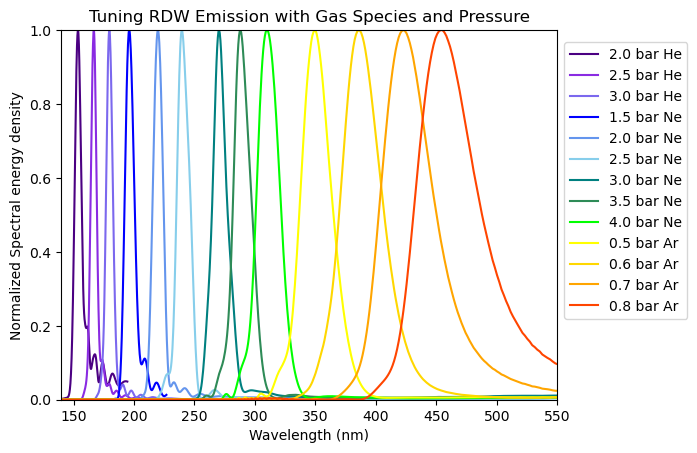

PyObject <matplotlib.legend.Legend object at 0x000001D20EC44DF0>

In [50]:
#graphs the normalized SED vs wavelength, based on for loop from stg3
#some arrays may need the wavelegnth to be cut off later/sooner than the 1300 for proper normalization or for cleanliness of graph

j=k #indexes column elements of compressor_stg3

for j in k:m #loops through all elements of function to graph pulse for all pressures/energies of stage 3
    graphs2_normSED_λ(compressor_stg3[a, j], j,a, pt2)
    j += 1
end

plt.legend(bbox_to_anchor=(1, .2), loc="best") #moves legend to outside the graph and populates with gas and pressure

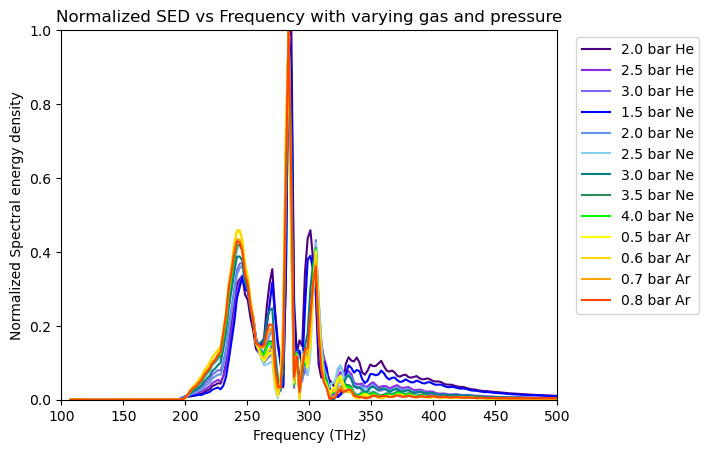

PyObject <matplotlib.legend.Legend object at 0x000001D2BF743A90>

In [13]:
#graphs the normalized SED vs frequency, based on for loop from stg3

j=k  #indexes column elements of compressor_stg3

for j in k:m #loops through all elements of function to graph pulse for all pressures/energies of stage 3
    graphs2_normSED_f(compressor_stg3[a, j], j)
    j += 1
end

plt.legend(bbox_to_anchor=(1.3, 1), loc="best") #moves legend to outside the graph and populates with gas and pressure

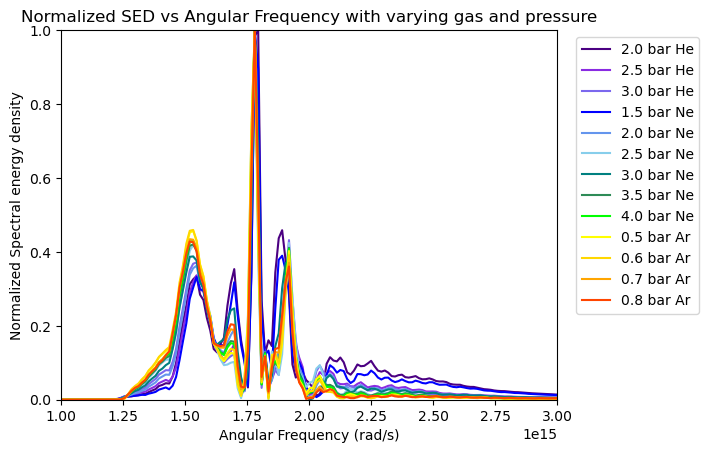

PyObject <matplotlib.legend.Legend object at 0x000001D295AE57E0>

In [14]:
#graphs the normalized SED vs angular frequency, based on for loop from stg3

j=k  #indexes column elements of compressor_stg3

for j in k:m #loops through all elements of function to graph pulse for all pressures/energies of stage 3
    graphs2_normSED_ω(compressor_stg3[a, j], j)
    j += 1
end

plt.legend(bbox_to_anchor=(1.3, 1), loc="best") #moves legend to outside the graph and populates with gas and pressure

(1453,)(1300,)(1453,)(1300,)(1453,)(1300,)(1453,)(1300,)(1453,)(1300,)(1453,)(1300,)(1453,)(1300,)(1453,)(1300,)(1453,)(1300,)(1453,)(1300,)(1453,)(1300,)(1453,)(1300,)(1453,)(1300,)

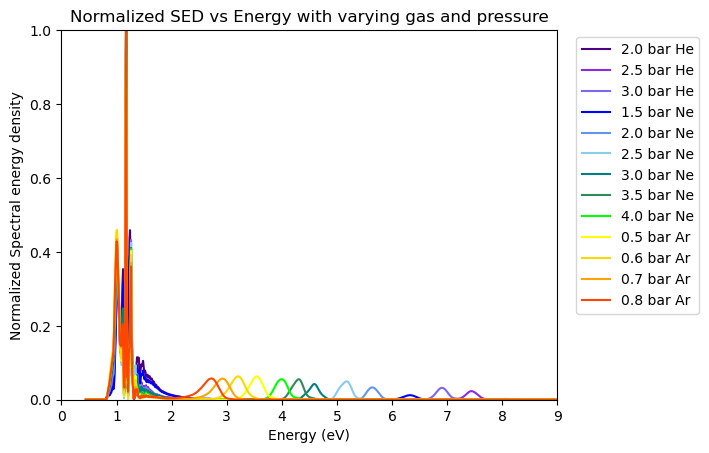

PyObject <matplotlib.legend.Legend object at 0x000001D2B82AA350>

In [15]:
#graphs the normalized SED vs eV, based on for loop from stg3

j=k  #indexes column elements of compressor_stg3

for j in k:m #loops through all elements of function to graph pulse for all pressures/energies of stage 3
    graphs2_normSED_e(compressor_stg3[a, j], a, j)
    j += 1
end

plt.legend(bbox_to_anchor=(1.3, 1), loc="best") #moves legend to outside the graph and populates with gas and pressure

(1453,)(1453,)(1453,)(1453,)(1453,)(1453,)(1453,)(1453,)(1453,)(1453,)(1453,)(1453,)(1453,)

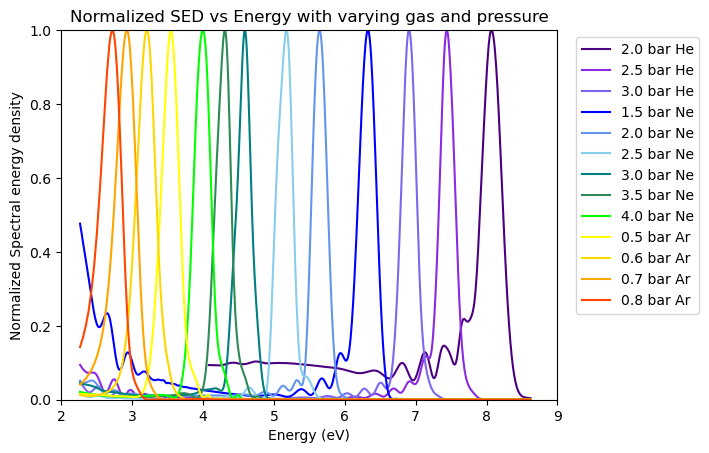

PyObject <matplotlib.legend.Legend object at 0x000001D2B89B4FD0>

In [17]:
#similar to norm SED vs EV but zoomed in on pulses

j=k  #indexes column elements of compressor_stg3

for j in 1:1 #elements split in for loops for correct normalizations
    #general plotting parameters
    plt.xlim(2, 9)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Normalized Spectral Energy Density")
    plt.ylim(0,1)
    plt.title("Tuning RDW with Gas Species and Pressure")

    #plotting arrays/variables
    f= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    f[j], Iλ[j]=Processing.getIω(compressor_stg3[a, j], :f,1) #get values of from the compressor function
    print(size(f[j]))
    f[j]=first(f[j],900) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 900) #need the arrays to be the same size for plotting
    f[j]=last(f[j],500) #filter out data points greater than window to normalize properly
    Iλ[j]=last(Iλ[j], 500) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(f[j]*4.14e-15, Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
end

for j in 2:m
    #general plotting parameters
    plt.xlim(2, 9)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Normalized Spectral energy density")
    plt.ylim(0,1)
    plt.title("Normalized SED vs Energy with varying gas and pressure")

    #plotting arrays/variables
    f= Array{Any}(undef,100) #arbituary lengths
    Iλ= Array{Any}(undef,100)
    Iλ_norm=Array{Any}(undef,100)
    color= Array(["indigo", "blueviolet", "mediumslateblue", "blue", "cornflowerblue", "skyblue", "teal", "seagreen", "lime", "yellow", "gold", "orange", "orangered", "red"])

    #gets SED and λ then normalizes SED to graph with legend 
    f[j], Iλ[j]=Processing.getIω(compressor_stg3[a, j], :f,1) #get values of from the compressor function
    print(size(f[j]))
    f[j]=first(f[j],900) #filter out data points greater than window to normalize properly
    Iλ[j]=first(Iλ[j], 900) #need the arrays to be the same size for plotting
    f[j]=last(f[j],700) #filter out data points greater than window to normalize properly
    Iλ[j]=last(Iλ[j], 700) #need the arrays to be the same size for plotting
    Iλ_norm[j]= (Iλ[j] / maximum(Iλ[j])) #normalize SED 
    plt.plot(f[j]*4.14e-15, Iλ_norm[j], label="$(pressure3[a,j]) bar $(gas3[a,j])", color="$(color[j])")
end

plt.legend(bbox_to_anchor=(1.3, 1), loc="best") #moves legend to outside the graph and populates with gas and pressure